<a href="https://colab.research.google.com/github/DanielGreiner/Masterarbeit/blob/main/CSTR_setup_V2_LH_4_koeff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Start

## LOAD LIBRARIES

In [ ]:
# @title import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import stats
import csv
from scipy.optimize import minimize

pd.options.mode.chained_assignment = None
pd.set_option('display.width', 200)

In [ ]:
#@title thermodynamics library

!pip install thermo
import thermo as thermo

In [ ]:
# @title check library versions
print("tensorflow:" + str(tf.__version__))
print("numpy:" + str(np.__version__))
print("pandas:" + str(pd.__version__))
#print("torch:" + str(to.__version__))

tensorflow:2.15.0
numpy:1.25.2
pandas:2.0.3


## SETUP


In [ ]:
#@title reactor constants

'''
Define all reactor specific constants and calculate size of finite differential for numerical integration
'''

L_R_big = 0.573 #0.720 Dennis Neu     # reactor length [m]          reactor split into two
d_R_big = 0.100 #0.133 Dennis Neu     # reactor diameter [m]        reactor split into two
m_cat_new = 3.535
L_R = 0.700                 # reactor length [m]
d_R = 0.010                 # reactor diameter [m]

r_R = d_R/2               # reactor radius [m]
r_R_big = d_R_big/2               # reactor radius [m]

A_R = np.pi*np.power(r_R, 2, dtype=float)               # reactor crossectional area [a.u.]
A_R_big = np.pi*np.power(r_R_big, 2, dtype=float)               # reactor crossectional area [a.u.]
V_R = A_R*L_R             # reactor volume [m^3]
V_R_big = A_R_big*L_R_big            # reactor volume [m^3]

m_cat = 2*m_cat_new       # catalyst mass [kg]
dens_cat_part = 3.28426*np.power(10, 3, dtype=float)    # catalyst particle density [kg m^-3]
dens_cat = 0.96*np.power(10, 3, dtype=float) #old:0.80*np.power(10, 3, dtype=float)      # catalyst bulk density [kg m^-3] use whichever

p_in = 1                  # inlet pressure [bar]
n_Flow_total = 3    # inlet molecular flowrate [mol h^-1]
x_MeOH_in = 0.5           # inlet molar fraction methanol
x_H2O_in = 0.5            # inlet molar fraction water
n_Flow_in_MeOH = x_MeOH_in * n_Flow_total         # inlet molecular flowrate methanol [mol h^-1]
n_Flow_in_H2O = x_H2O_in * n_Flow_total           # inlet molecular flowrate water [mol h^-1]

R = 8.314                 # universal gas constant [J mol-1 K-1]

M_MeOH = 32.042 #g/mol bzw. kg/kmol
M_H2O = 18.02 #g/mol bzw. kg/kmol
M_H2 = 2.016 #g/mol bzw. kg/kmol
M_CO = 28.010 #g/mol bzw. kg/kmol
M_CO2 = 44.009 #g/mol bzw. kg/kmol

M_array = np.array([M_H2, M_H2O, M_CO, M_CO2, M_MeOH])

# Ergun equation values, partially preliminary
D_cat = 1*np.power(10, -3, dtype=float)                    # catalyst particle diameter [m]
eps = 0.4                 # void fraction in packed bed; assumption = spherical & nearly ideally packed
vel_gas = n_Flow_total/(p_in*np.power(10, 5, dtype=float))*R*(150+273)         # gas velocity [m s^-1]

steps = 200               # number of steps in numerical calculation

# deactivation

#deactivation_spacing = 10

# segment to test constants

#print(dm_cat)
#print(m_cat_span)
#print(len(Vspansplit))
#print(stepssplit)
# print(dens_cat)
# print(dens_cat_part)
# print(dens_cat_bulk)

A = 0.0188068
B = 0.06958716
C = 0.005
D = 0.005


In [ ]:
#@title heat duty constants

a_a = 150   #Aziz
a_i = 15    #Aziz
ds = 0.01   #Aziz
lamb = 15   #8 preliminary
k_w = 1/(1/a_i+1/a_a+ds/lamb)
a_w_big = np.pi*d_R_big/A_R_big   # 1/m
a_w = np.pi*d_R/A_R   # 1/m
# print(k_w)
print(k_w)
print(a_w)

DH_MSR = 49*10^6 # J/kmol
DH_MD = 90*10^6 # J/kmol

13.513513513513514
400.00000000000006


In [ ]:
#@title Initial concentrations
'''
setup initial concentrations in an IC array:
'''

n0_H2 = 0                       # [kmol h^-1]
n0_H2O = n_Flow_in_H2O/1000     # [kmol h^-1]
n0_CO = 0                       # [kmol h^-1]
n0_CO2 = 0                      # [kmol h^-1]
n0_MeOH = n_Flow_in_MeOH/1000   # [kmol h^-1]

IC = np.array([n0_H2, n0_H2O, n0_CO, n0_CO2, n0_MeOH])
IC_zs_0 = IC/np.sum(IC)

In [ ]:
#@title thermo

# SI units
# Cpg = [J/kg/K]
# rhog = [kg/m^3]
# mug = [Pa/s]

# H2 = thermo.Chemical('hydrogen', T=450, P=1E5)
# print(H2.Cpg)
# H2O = thermo.Chemical('water', T=450, P=1E5)
# print(H2O.Cpg)
# CO = thermo.Chemical('carbon monoxide', T=450, P=1E5)
# print(CO.Cpg)
# CO2 = thermo.Chemical('carbon dioxide', T=450, P=1E5)
# print(CO2.Cpg)
# MeOH = thermo.Chemical('methanol', T=450, P=1E5)
# print(MeOH.Cpg)

gas_mix_names = ['hydrogen', 'water', 'carbon monoxide', 'carbon dioxide', 'methanol']

gas_prop = thermo.Mixture(gas_mix_names, zs=IC_zs_0, T=450, P=1E5)
print('Spezifische Wärmekapazität der Gasmixtur = ' + str(gas_prop.Cpg) + ' J/kg/K')
print('Dichte der Gasmixtur = ' + str(gas_prop.rhog) + ' kg/m^3')
print('Dynamische Viskosität der Gasmixtur = ' + str(gas_prop.mug) + ' Pa/s')

Spezifische Wärmekapazität der Gasmixtur = 1805.3325184046016 J/kg/K
Dichte der Gasmixtur = 0.6689433460559383 kg/m^3
Dynamische Viskosität der Gasmixtur = 1.5083679245089485e-05 Pa/s


In [ ]:
#@title kinetics data

'''
setup kinetics data in arrays, includes S-Kinetics for the MSR and MD reactions respectively
includes activation energies, k0 and exponents for rate of reaction calculation using a modified arrhenius equation
'''

T0 = 150 + 273    # T0 to calculate arrhenius' rate of reaction constant k [K]
n = 1             # exponent in arrhenius equation

#BiCat
#MSR
k0_MSR_S = 8.5*np.power(10, -7, dtype=float)       # k0 for arrhenius[kmol kg^-1 h^-1 Pa^-b]
EA_MSR_S = 54186              # activation energy [J mol-1]
b_MeOH_MSR_S = 0.570           # rate of reaction exponent for methanol
b_H2O_MSR_S = 0.049           # rate of reaction exponent for water

#reverse MSR reaction

k0_MSR_S_rev = 4.2*np.power(10, -6, dtype=float)       # k0 for arrhenius[kmol kg^-1 h^-1 Pa^-b]
EA_MSR_S_rev = 4978                   # activation energy [J mol-1]
b_MeOH_MSR_S_rev = - 0.428            # rate of reaction exponent for methanol
b_H2O_MSR_S_rev = - 0.949             # rate of reaction exponent for water

MSR = np.array(
    [[k0_MSR_S, EA_MSR_S, b_MeOH_MSR_S, b_H2O_MSR_S],
    [k0_MSR_S_rev, EA_MSR_S_rev, b_MeOH_MSR_S_rev, b_H2O_MSR_S_rev]]
)

#MD
k0_MD_S = 1.2*np.power(10, -11, dtype=float)        # [kmol kg^-1 h^-1 Pa^-b]
EA_MD_S = 132540                  # [J mol-1]
b_MeOH_MD_S = 1.114

#reverse MD reaction

k0_MD_S_rev = 5.5*np.power(10, -8, dtype=float)        # [kmol kg^-1 h^-1 Pa^-b]
EA_MD_S_rev = 42137               # [J mol-1]
b_MeOH_MD_S_rev = 0.114

MD = np.array (
    [[k0_MD_S, EA_MD_S, b_MeOH_MD_S],
    [k0_MD_S_rev, EA_MD_S_rev, b_MeOH_MD_S_rev]]
)

# array for stoichiometric coefficients
ny = np.array(
    [[3, -1, 0, 1, -1],
    [2, 0, 1, 0, -1]]
)


# testing block for kinetics arrays


# print(MSR)
# print(MSR[1,1])
#print(ny)

In [ ]:
#@title deactivation slope

deactivation_reading = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/deactivation value.csv')

# old, for use with old deactivation calc from this notebook, reactivate in deactivation function if needed

deactivation_value_csv = deactivation_reading.iat[0, 0]

deactivation_list = {}

## import experimental results

In [ ]:
#@title import experimental results to compare

filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/db for kinetic model.csv'
kinetic_experimental = pd.read_csv(filepath, sep=',')

kinetic_experimental['Conversion Model [%]'] = 0

# Reactor

## PFTR ISOTHERMAL AND STEADY STATE

### ODE by mass catalyst:


$\Large\frac{d\dot{n}_x}{dm_{cat}}=R_x$

$\Large\require{enclose} \frac{dT}{dm_{cat}} = \frac{∑r_i⋅(-𝛥_rH_{m, i}^\enclose{horizontalstrike}{o})}{\dot{m}⋅c_{p, g}}+\frac{k_w\cdot
a_w}{(1-ϵ)⋅ρ_{cat}\dot{m}⋅c_{p, g}}⋅(T_W-T)$

In [ ]:
# @title reaction functions

def ReakFun (P, T, p_in):
  '''
  calculates the rate of reaction for each component for MSR and MD reactions with respect to the selected catalytic system through indexing
  '''
  # creates new empty concentration array for the components
  dP=np.zeros(len(P))

  # total molar flowrate
  n_ges_temp = np.sum(P[:])

  # calculates molar fraction of all 5 components; original array contains catalyst mass -> ignored in this calculation
  # molar fraction times total pressure = partial pressure; calculated for all 5 components
  for j in range(5):
    P[ j] = P[ j]/n_ges_temp*np.power(10, 5, dtype=float)*1.013 #*p_in

  # assigns components to array index for better readability of calculations
  P_H2 = P[0]
  P_H2O = P[1]
  P_CO = P[2]
  P_CO2 = P[3]
  P_MeOH = P[4]

  # calculates the rate of reaction for each reaction pathway and every catalyst setup
  rMSR = MSR[0, 0] *np.power((T/T0), n, dtype=float)*np.exp((-MSR[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMSR *= A*P_MeOH*B*P_H2O/(1 + A*P_MeOH + B*P_H2O)

  # if statement necessary as exponents in reverse reactions are negative -> might divide by zero
  if P_MeOH > 0 and P_H2O > 0:
    revMSR = MSR[1, 0] *np.power((T/T0), n, dtype=float)*np.exp((-MSR[1, 1]/R)*(1/T-1/T0), dtype=float)
    revMSR *= C*P_H2*D*P_CO2/(1 + C*P_H2 + D*P_CO2)*-1
  else:
    revMSR = 0

  rMD = MD[0, 0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMD *= A*P_MeOH/(1 + A*P_MeOH)

  if P_MeOH > 0:
    revMD = MD[1, 0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[1, 1]/R)*(1/T-1/T0), dtype=float)
    revMD *= C*P_CO/(1 + C*P_CO)*-1
  else:
      revMD = 0

  # calculates slope of change for each component and returns the result
  dP[0] = (rMSR*ny[0, 0] + rMD*ny[1, 0])+(revMSR*ny[0, 0] + revMD*ny[1, 0])
  dP[1] = (rMSR*ny[0, 1] + rMD*ny[1, 1])+(revMSR*ny[0, 1] + revMD*ny[1, 1])
  dP[2] = (rMSR*ny[0, 2] + rMD*ny[1, 2])+(revMSR*ny[0, 2] + revMD*ny[1, 2])
  dP[3] = (rMSR*ny[0, 3] + rMD*ny[1, 3])+(revMSR*ny[0, 3] + revMD*ny[1, 3])
  dP[4] = (rMSR*ny[0, 4] + rMD*ny[1, 4])+(revMSR*ny[0, 4] + revMD*ny[1, 4])

  return dP

In [ ]:
# @title reaction functions without reverse reaction

def ReakFunNoReverse (P, T, p_in):
  '''
  calculates the rate of reaction for each component for MSR and MD reactions with respect to the selected catalytic system through indexing
  '''
  # creates new empty concentration array for the components and assigns components to index
  dP=np.zeros(len(P))

  # total molar flowrate
  n_ges_temp = np.sum(P[ :])

  # calculates molar fraction of all 5 components; original array contains catalyst mass -> ignored in this calculation
  # molar fraction times total pressure = partial pressure; calculated for all 5 components
  for j in range(5):
    P[ j] = P[ j]/n_ges_temp*p_in*np.power(10, 5, dtype=float)


  P_H2 = P[0]
  P_H2O = P[1]
  P_CO = P[2]
  P_CO2 = P[3]
  P_MeOH = P[4]
  m_cat_x = P[5]

  # calculates the rate of reaction for each reaction pathway and every catalyst setup
  rMSR = MSR[0, 0] *np.power((T/T0), n, dtype=float)*np.exp((-MSR[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMSR *= np.power(P_MeOH, MSR[0, 2], dtype=float)*np.power(P_H2O, MSR[0, 3], dtype=float)


  rMD = MD[0, 0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMD *= np.power(P_MeOH, MD[0, 2], dtype=float)


  # calculates slope of change for each component and returns the result
  dP[0] = (rMSR*ny[0, 0] + rMD*ny[1, 0])
  dP[1] = (rMSR*ny[0, 1] + rMD*ny[1, 1])
  dP[2] = (rMSR*ny[0, 2] + rMD*ny[1, 2])
  dP[3] = (rMSR*ny[0, 3] + rMD*ny[1, 3])
  dP[4] = (rMSR*ny[0, 4] + rMD*ny[1, 4])
  dP[5] = 1

  return dP

## Deactivation

In [ ]:
# @title deactivation function

# def DeacFun(X_t_T_p):
#   '''
#   uses a deactivation function to calculate the change in catalytic efficiency given a time array
#   '''
#   # the calculation is preliminary and will be corrected later with respect to the present pressure
#   # just to test if deactivation function works and can be implemented

#   Xt = X_t_T_p.copy()

#   deactivation_slope_old = 0

#   for i in range(len(Xt)):
#     if i == 0:
#         deactivation_slope = (deactivation_reading.iat[0, 1] * (Xt[i, 1]) + deactivation_reading.iat[0, 0] * (Xt[i, 1])**2) * Xt[i, 2]
#     else:
#         deactivation_slope = (deactivation_reading.iat[0, 1] * (Xt[i, 1] - Xt[i -1, 1]) + deactivation_reading.iat[0, 0] * (Xt[i, 1] - Xt[i -1, 1])**2) * Xt[i, 2]
#     deactivation_slope_total = deactivation_slope + deactivation_slope_old
#     Xt[i, 0] = Xt[i, 0] * (1 + deactivation_slope_total)
#     deactivation_slope_old = deactivation_slope_total

#   for i in range(len(Xt)):
#     if Xt[i, 0] < 0:
#         Xt[i, 0] = 0

#   return Xt

# old, with just one activation value from this notebook, new from deactivation data

def DeacFun(X_t_T_p):
  '''
  uses a deactivation function to calculate the change in catalytic efficiency given a time array
  '''
  # the calculation is preliminary and will be corrected later with respect to the present pressure
  # just to test if deactivation function works and can be implemented

  Xt = X_t_T_p.copy()

  deactivation_slope_old = 0

  for i in range(len(Xt)):
    if i == 0:
        deactivation_slope = deactivation_value_csv * Xt[i, 2] * (Xt[i, 3]**2.228) * (Xt[i, 1])
    else:
        deactivation_slope = deactivation_value_csv * Xt[i, 2] * (Xt[i, 3]**2.228) * (Xt[i, 1] - Xt[i -1, 1])
    deactivation_slope_total = deactivation_slope + deactivation_slope_old
    Xt[i, 0] = Xt[i, 0] * (1 + deactivation_slope_total)
    deactivation_slope_old = deactivation_slope_total

  for i in range(len(Xt)):
    if Xt[i, 0] < 0:
        Xt[i, 0] = 0

  return Xt

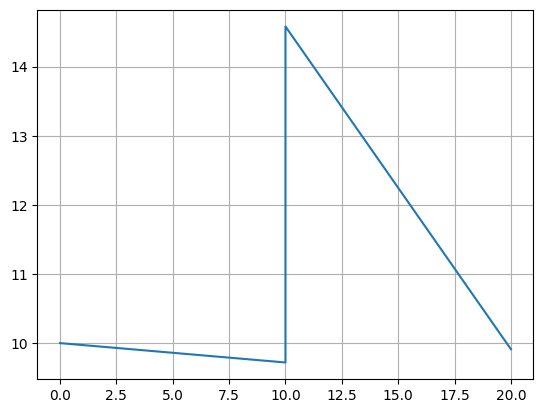

In [ ]:
#@title deactivation debugging and testing

# deactivation_value = -0.00005

X = np.array([[10.0, 0, 427, 1], [10.0, 10, 427, 1], [15.0, 10, 427, 1], [10.5, 20, 427, 1]])
xz = DeacFun(X)


plt.plot(xz[:, 1], xz[:, 0])
plt.grid()

# MAIN

In [ ]:
#@title Main calculation, molar flowrate result

def MainCalcMolFlow (y, T, p_in, no_rev, mcat):

  n_in = y.copy()

  if no_rev == 1:
    temp_solution = ReakFunNoReverse(n_in, T, p_in)
  else:
    temp_solution = ReakFun(n_in, T, p_in)

  n_out = y + mcat*temp_solution
  for i in range(len(n_out)):
    if n_out[i] < 0:
        n_out[i] = 0
  #print(y, n_in, temp_solution, n_out)
  return n_out

In [ ]:
#@title main function

'''
contains main function to call all other relevant functions and set temperature and reaction index
'''
# set reaction temperature and calculate respective volumetric flowrate

T = 273 + 150           # K
m_cat = 5/1000          # kg

initial_c = IC.copy()

pEulMF = MainCalcMolFlow(initial_c, T, 1, 0, m_cat)

pEulfractemp = pEulMF.copy()

pEulfrac = pEulfractemp[:]/np.sum(pEulfractemp)

x_MeOH = (1 - pEulMF[4]/IC[4])*100

print(x_MeOH)

0.03580639355733606


# Main Plots

## MAIN PLOTS

In [ ]:
#@title insert relevant plots here

## PRODUCTION PLOTS || Preliminary

In [ ]:
#  # @title total hydrogen production plot
# '''
# plots total hydrogen production over time
# data includes deactivation
# '''
# plt.figure(1)
# plt.plot(production_time, production_total)
# plt.title("total hydrogen production")
# plt.xlim(production_time_0, production_time_max)
# plt.ylim(bottom = production_time_0)
# plt.grid()
# plt.xlabel("time [h]")
# plt.ylabel ("hydrogen production [kmol]")

In [ ]:
# # @title hourly hydrogen production
# '''
# plots hourly hydrogen production
# shows deactivation
# '''
# plt.figure(1)
# plt.plot(production_time, production_hourly)
# plt.title("hourly hydrogen production")
# plt.xlim(production_time_0, production_time_max)
# plt.ylim(bottom = production_time_0)
# plt.grid()
# plt.xlabel("time [h]")
# plt.ylabel ("hydrogen production [kmol]")

# results

In [ ]:
#@title populate results df

for i in range(len(kinetic_experimental)):

    n_H2O = kinetic_experimental['Flowrate [kmol/h] H2O'].iat[i]
    n_MeOH = kinetic_experimental['Flowrate [kmol/h] MeOH'].iat[i]

    IC_popdf = np.array([0, n_H2O, 0, 0, n_MeOH, 0])

    T = kinetic_experimental['Temperature [°C]'].iat[i] + 273
    p_in = 1

    m_cat_new = kinetic_experimental['Cat mass [kg]'].iat[i]

    results = MainCalcMolFlow(IC_popdf, T, p_in, 0, m_cat_new)

    if n_MeOH <= n_H2O:
        kinetic_experimental['Conversion Model [%]'].iat[i] = (1-results [4]/(n_MeOH))*100

    else:
        kinetic_experimental['Conversion Model [%]'].iat[i] = (1-results [1]/(n_H2O))*100


kinetic_experimental['Squared diff'] = ((kinetic_experimental['Conversion [%]']- kinetic_experimental['Conversion Model [%]'])*100)**2
result_kin = kinetic_experimental['Squared diff'].sum()


In [ ]:
kinetic_experimental

,Temperature [°C],Cat mass [kg],Flowrate [kmol/h] MeOH,Flowrate [kmol/h] H2O,Conversion [%],Conversion Model [%],Squared diff
0,149.889299,0.005002,0.000027,0.000053,8.491247,8.879288,1505.759806
1,145.000067,0.005002,0.000027,0.000053,6.675897,7.328905,4264.204715
2,140.386979,0.005001,0.000053,0.000027,8.245776,8.972978,5288.232681
3,144.949103,0.005001,0.000053,0.000027,10.909101,10.775623,178.165591
4,140.678263,0.005001,0.000053,0.000027,8.543868,9.079538,2869.416824
5,149.563791,0.005001,0.000053,0.000027,13.527396,12.917241,3722.897280
6,140.148304,0.005001,0.000053,0.000027,8.490685,8.886490,1566.614264
7,140.152650,0.006084,0.000040,0.000040,6.596527,6.557644,15.119140
8,145.232329,0.006084,0.000040,0.000040,8.419769,8.040142,1441.167943
9,150.044268,0.006084,0.000040,0.000040,10.437894,9.709837,5300.661838


Text(0.5, 0, 'Model conversion [%]')

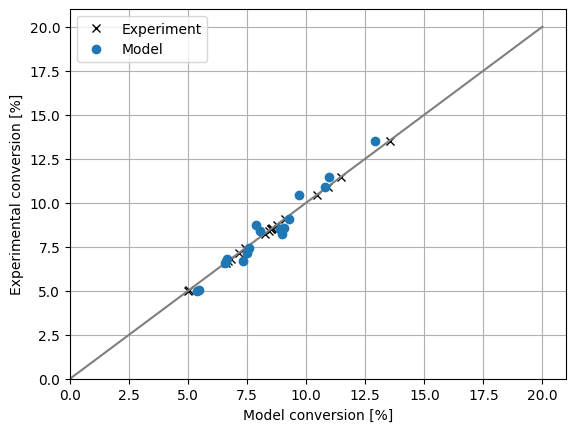

In [ ]:
#@title parity model experiment

plt.figure(1)

plt.plot(kinetic_experimental['Conversion [%]'], kinetic_experimental['Conversion [%]'], color = 'k', linestyle = 'None', marker = 'x', label = 'Experiment')
plt.plot([0, 20], [0, 20], color = 'tab:gray')
plt.plot(kinetic_experimental['Conversion Model [%]'], kinetic_experimental['Conversion [%]'], marker = 'o', linestyle = 'None', label = 'Model')

plt.legend(loc='best')
plt.grid()
plt.ylim(bottom = 0)
plt.xlim(left = 0)

plt.ylabel('Experimental conversion [%]')
plt.xlabel('Model conversion [%]')

# Data comparison

## Aspen Comparison

In [ ]:
# @title comparative aspen arrays

# '''
# contains main function to call all other relevant functions, set comperative temperature/reaction data and create comperative aspen results arrays
# '''
# # extracts excel file from google drive, using pandas library
# xl = pd.ExcelFile('/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/Results 720mm reactor by temp.xlsx')

# # set temperature iterations and results array according to the makeup of the excel file
# AspenPoints = len(xl.sheet_names)
# AspenResults = np.zeros([AspenPoints, 11, len(IC)])
# sheets = xl.sheet_names

# # extract temperature step and boundaries according to excel file
# AspenStartingTemp = int(''.join(filter(str.isdigit, sheets[0])))
# AspenSecondTemp = int(''.join(filter(str.isdigit, sheets[1])))
# AspenEndTemp = int(''.join(filter(str.isdigit, sheets[-1])))
# diff = AspenSecondTemp - AspenStartingTemp

# # sets stepsize specific to aspen
# steps_Aspen = 100

# # set aspen specific reactor data
# L_R_Aspen = 0.720
# d_R_Aspen = 0.133
# r_R_Aspen = d_R_Aspen/2
# A_R_Aspen = np.pi*np.power(r_R_Aspen, 2, dtype=float)
# V_R_Aspen = A_R_Aspen*L_R_Aspen

# # set aspen specific catalyst data, create differention variable and size
# m_cat_Aspen = 7.95
# m_cat_0_Aspen = 0
# dm_cat_Aspen = (m_cat_Aspen-m_cat_0_Aspen)/steps_Aspen
# m_cat_span_Aspen = np.arange(m_cat_0_Aspen, m_cat_Aspen + dm_cat_Aspen, dm_cat_Aspen)
# dens_cat_Aspen = m_cat_Aspen/V_R_Aspen

# # set boundaries according to aspen excel file
# T_min = AspenStartingTemp + 273                                              # minimum temperature boundary [K]
# T_max = AspenEndTemp + 273                                                   # maximum temperature boundary [K]
# T_stepsize = diff                                                            # temperature change per loop iteration [K]

# temperature_arr = np.arange(0, AspenPoints)*T_stepsize + T_min               # sets temperature array to be examined
# pEulTemps = np.zeros([AspenPoints, len(m_cat_span_Aspen), len(IC)])          # setup of results array

# # turns the results in the aspen excel file into arrays, rearranges results columns to mirror model array setup
# for i in range(AspenPoints):
#   df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/Results 720mm reactor by temp.xlsx', i)

#   df = df[['H2', 'H2O', 'CO', 'CO2', 'MEOH-1', 'Length']]
#   tempres = df.to_numpy()
#   res = np.delete(tempres, (0), axis=0)
#   AspenResults [i, :, :] = res

# # calls euler function and writes results to master 3D array
# for i in range (AspenPoints):
#   T = temperature_arr [i]                                                 # reactor temperature [K]
#   VFlow = n_Flow_total*R*T/(p_in * np.power(10, 5, dtype = float))        # volumetric flowrate [m^3 h^-1]
#   pEulTemps [i, :, :] = EulFun(IC, T, p_in, m_cat_span_Aspen, dm_cat_Aspen, steps_Aspen, 0, a_w_big)
#   pEulTemps [i, :, 5] = pEulTemps [i, :, 5] / dens_cat_Aspen / A_R_Aspen

# # turns pressure to molar fraction
# pEulTemps[:, :-1] = pEulTemps[:, :-1]/p_in

In [ ]:
# @title transform results to aspen
# '''
# used to transform the aspen results array into excel file and save to google drive
# redo if comparison changes
# '''

# writer = pd.ExcelWriter('/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/aspen model comparisons.xlsx')

# for i in range(AspenPoints):
#     df = pd.DataFrame(pEulTemps[i, :, :])
#     tempname = i*diff + AspenStartingTemp
#     df.columns = ['H2', 'H2O', 'CO', 'CO2', 'MEOH-1', 'Mass catalyst']
#     df.to_excel(writer, sheet_name = 'T = '+ str(tempname))

# df
# writer.save()


## Experimental Data Schwarz

### EXPERIMENTAL DATA 72_02

#### Data manip

In [ ]:
#@title experimental data extraction | simple | for now

molar_volume_ideal_gas = 24210 # [ml mol-1]
V_lN_in_default_72 = 0.0023 #[lN h^-1]
n_in_default_72 = 0.08/1000 #[kmol h^-1]
n_in_default_72_array = np.array([0.00157*60/2/1000, 0.00170*60/2/1000, 0.00165*60/2/1000, 0.00160*60/2/1000, 0.00158*60/2/1000, 0.00152*60/2/1000, 0.00158*60/2/1000])

filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/CS_72_02.xlsx'
default_72 = pd.read_excel(filepath, sheet_name ='Ergebnisse', usecols='B:E, G:I', header = 5)
default_72 = default_72.dropna(how='all')
units = default_72.head(1)
default_72 = default_72.drop(0, axis=0)
cat_mass_default_72 = pd.read_excel(filepath, sheet_name ='Ergebnisse')
cat_mass_default_72 = cat_mass_default_72.head(2)['Katalysator']
cat_mass_default_72 = cat_mass_default_72[1]/1000
default_72['group']= (default_72['Reactor Temperature'].diff()!= 0).cumsum()
default_72_molar_fraction_base = default_72['COppm'] + default_72['CO2'] + default_72['H2']
default_72['CO Flow'] = default_72['COppm']/default_72_molar_fraction_base*default_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
default_72['CO2 Flow'] = default_72['CO2']/default_72_molar_fraction_base*default_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
default_72['H2 Flow'] = default_72['H2']/default_72_molar_fraction_base*default_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
default_72['H2:CO2 ratio'] = default_72['H2 Flow']/default_72['CO2 Flow']
default_72['X_{MeOH} [%]'] = (1 - ((n_in_default_72/2)*1000-(default_72['CO2 Flow']+default_72['CO Flow']))/((n_in_default_72*1000)/2))*100

criteria = default_72.groupby('group')['group'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
default_72_means = default_72[criteria].groupby('group').mean()
default_72_means['n. MeOH in2'] = [0.00157*60/2, 0.00170*60/2, 0.00165*60/2, 0.00160*60/2, 0.00158*60/2, 0.00152*60/2, 0.00158*60/2]
default_72_means['X_{MeOH} [%]2'] = (1 - (default_72_means['n. MeOH in2']-default_72_means['CO2 Flow']-default_72_means['CO Flow'])/default_72_means['n. MeOH in2'])*100

# @title misc calcs

default_72_means_array = default_72_means.to_numpy()
compEul_default_72 = np.zeros([len(default_72_means_array), len(IC)])

prodFlow_default_72_model = np.zeros([len(default_72_means_array)])
H2CO2_ratio_default_72 = np.zeros([len(default_72_means_array)])
conversion_default_72_model = np.zeros([len(default_72_means_array)])

for i in range (len(default_72_means_array)):
  #IC_default_72 = np.array([0, n_in_default_72/2, 0, 0, n_in_default_72/2, 0])
  IC_default_72 = np.array([0, n_in_default_72_array[i], 0, 0, n_in_default_72_array[i], 0])
  T_72 = default_72_means_array[i, 1] + 273
  p_72 = default_72_means_array[i, 2]
  compEul_default_72 [i,  :] = MainCalcMolFlow(IC_default_72, T_72, p_72, 0, cat_mass_default_72)
  prodFlow_default_72_model [i] = (compEul_default_72 [i, 0] + compEul_default_72 [i, 2] + compEul_default_72 [i, 3]) *molar_volume_ideal_gas/60*1000
  H2CO2_ratio_default_72 [i] = compEul_default_72 [i, 0]/compEul_default_72 [i, 3]
  conversion_default_72_model [i] = (1-compEul_default_72 [i, 4]/(n_in_default_72_array[i]))*100

default_72_means_production_flow = default_72_means['Productgas FlowGasanalyzer'].to_numpy()
default_72_means_methanol_conversion = default_72_means['X_{MeOH} [%]2'].to_numpy()

offset_to_experiment_production = (1 - prodFlow_default_72_model/default_72_means_production_flow)*100
offset_to_experiment_conversion = (1 - conversion_default_72_model/default_72_means_methanol_conversion)*100

# print('last results entry in each iteration: ', end='\n\n')
# print(compEul_default_72[:, -1, :])
# print(prodFlow_default_72)
# print(H2CO2_ratio_default_72)
# print(dm_cat_mass_default_72)

# xx = np.zeros(len(default_72_means_array))
# xx = (1-compEul_default_72[:, -1, 4]/compEul_default_72[:, 0, 4])*100
# print('Umsatzgrade: ' , xx)

In [ ]:
# @title results table

print(units, end='\n\n\n')
# print('mass catalyst used = ' + str(cat_mass_default_72*1000) + 'g', end='\n\n\n')
print(default_72_means)

  Time Reactor Temperature Reactor Pressure COppm  CO2   H2 Productgas FlowGasanalyzer
0    h                  °C           barabs   ppm  ppm  ppm                   ml min-1


          Time Reactor Temperature Reactor Pressure       COppm           CO2             H2 Productgas FlowGasanalyzer   CO Flow  CO2 Flow   H2 Flow H2:CO2 ratio X_{MeOH} [%]  n. MeOH in2  \
group                                                                                                                                                                                          
1       6.2502               150.0          1.03351  225.804759  58805.432783  187926.622198                   8.399757  0.000019  0.004957  0.015841     3.195772    12.439983       0.0471   
2      12.7502               120.0          1.03076   19.896372  21333.901768   63517.350587                   2.375622  0.000001   0.00148  0.004406     3.013448      3.70415       0.0510   
3      18.7502               130.0         1.029598   37

In [ ]:
# @title printing

print("prodFlow_default_72_model", end="\n")
print(prodFlow_default_72_model, end="\n\n")
print("default_72_means_production_flow", end="\n")
print(default_72_means_production_flow, end="\n\n")
print("conversion_default_72_model", end="\n")
print(conversion_default_72_model, end="\n\n")
print("default_72_means_methanol_conversion", end="\n")
print(default_72_means_methanol_conversion, end="\n\n")
print("offset_to_experiment_production", end="\n")
print(offset_to_experiment_production, end="\n\n")
print("offset_to_experiment_conversion", end="\n")
print(offset_to_experiment_conversion, end="\n\n")

prodFlow_default_72_model
[5.48647918 1.57234298 2.43318947 3.68877822 5.48647918 8.01638372
 5.48647918]

default_72_means_production_flow
[8.399756583435469 2.375621576078297 3.70673391181258 5.780041575072024
 8.119778203411176 9.89930682388628 7.157570273401386]

conversion_default_72_model
[ 7.2172093   1.91017686  3.04556028  4.76143411  7.17153076 10.89206259
  7.17153076]

default_72_means_methanol_conversion
[10.56474119017652 2.905215321204302 4.301926332185202 7.067485193198852
 10.170793170416426 13.100584894702404 9.086937946501884]

offset_to_experiment_production
[34.68287891432017 33.81340707973739 34.35759009851566 36.180766643342075
 32.4306767862206 19.02075705057752 23.347183905500803]

offset_to_experiment_conversion
[31.6858863880645 34.25007608036764 29.204731968489106 32.629018988501876
 29.488972596023444 16.85819622266824 21.078686771985044]



In [ ]:
# @title testing block, ignore

# print(prodFlow_default_72)
# print(default_72_means_production_flow)
# print(offset_to_experiment)

In [ ]:
#@title deactivation

default_72_reg = default_72[(default_72['X_{MeOH} [%]'] > 2)]

reg_criteria = default_72_reg.groupby('group')['group'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
default_72_reg = default_72_reg[reg_criteria]

default_72_deactivation_data = np.zeros((len(default_72_means) * 2, 4))
for i in range(len(default_72_means)):
        default_72_deactivation_data [i*2, :] = (conversion_default_72_model [i], default_72[default_72['group'] == i + 1]['Time'].iat[0], default_72_means.iat[i, 1] + 273, default_72_means.iat[i, 2])
        default_72_deactivation_data [i*2 + 1, :] = (conversion_default_72_model [i], default_72[default_72['group'] == i + 1]['Time'].iat[-1], default_72_means.iat[i, 1] + 273, default_72_means.iat[i, 2])

default_72_regression_fit = np.zeros((len(default_72_means), 2))
default_72_regression_trend = {}

regression_array_default_72 = np.zeros(len(default_72_means))

x1 = list(default_72_reg['Time'])

for i in range(len(default_72_means)):
    x11 = list(default_72_reg[default_72_reg['group'] == i + 1]['Time'])
    y11 = list(default_72_reg[default_72_reg['group'] == i + 1]['X_{MeOH} [%]'])

    default_72_regression_fit[i, :] = np.polyfit(x11, y11, deg = 1)
    default_72_regression_trend [i] = [x11, np.polyval(default_72_regression_fit[i, :], x11)]

    # for j in range(len(default_72_reg[default_72_reg['group'] == i]['Time'])):
    #     default_72_regression_trend[len(default_72_reg[default_72_reg['group'] == i - 1]['Time']) + j] = default_72_regression_trend_temp[j]

Xt_default = np.zeros((len(default_72_deactivation_data), 2))

Xt_default = DeacFun(default_72_deactivation_data)

for i in range(len(default_72_means)):
    regression_array_default_72[i] = default_72_regression_fit[i, 0]/conversion_default_72_model[i]/(default_72_means_array[i, 1] + 273)/(default_72_means_array[i, 2]**2.228)

print("regression polyfit: " + str(default_72_regression_fit[:, 0]))
print("regression array: " + str(regression_array_default_72))

# playing around with deactivation value extraction

#deactivation_list[0] = regression_array_default_72

regression polyfit: [ 0.0161623  -0.50507013  0.12978892  0.04663289 -0.02232068 -0.19163849
 -0.1492645 ]
regression array: [ 4.91927127e-06 -6.28884594e-04  9.90926738e-05  2.23745054e-05
 -7.23346645e-06 -3.99638582e-05 -4.85121619e-05]


#### plots

Text(0, 0.5, 'model flowrate [ml min$^{-1}$]')

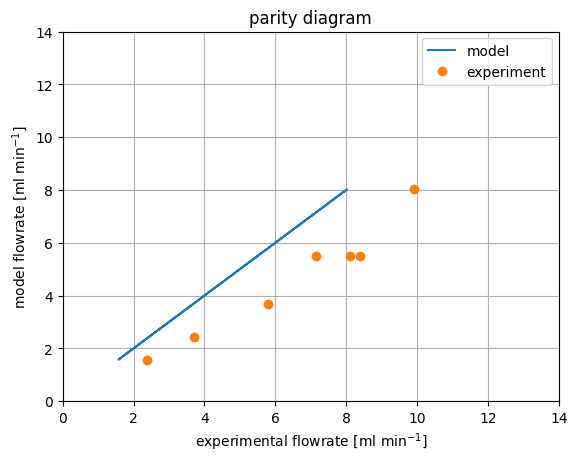

In [ ]:
# @title parity plot flowrates

plt.figure(1)
plt.plot(prodFlow_default_72_model, prodFlow_default_72_model, label='model')
plt.plot(default_72_means_production_flow, prodFlow_default_72_model, label='experiment', marker='o', linestyle='')
plt.title('parity diagram')
plt.legend(loc='best')
plt.axis((0, 14, 0, 14))
plt.grid()
plt.xlabel("experimental flowrate [ml min$^{-1}$]")
plt.ylabel ("model flowrate [ml min$^{-1}$]")

Text(0, 0.5, 'model conversion [%]')

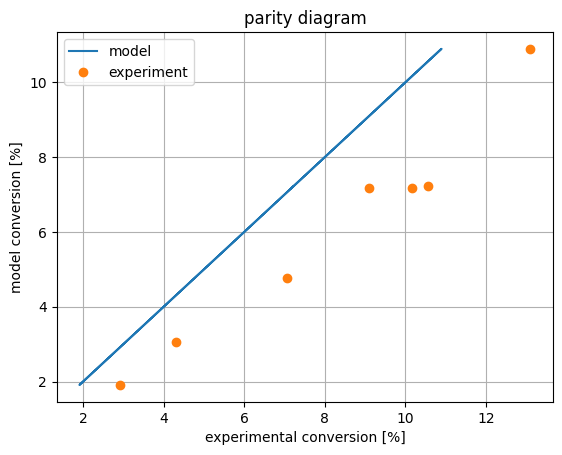

In [ ]:
# @title parity plot conversion

plt.figure(1)
plt.plot(conversion_default_72_model, conversion_default_72_model, label='model')
plt.plot(default_72_means_methanol_conversion, conversion_default_72_model, label='experiment', marker='o', linestyle='')
plt.title('parity diagram')
plt.legend(loc='best')
#plt.axis((0, 14, 0, 14))
plt.grid()
plt.xlabel("experimental conversion [%]")
plt.ylabel ("model conversion [%]")

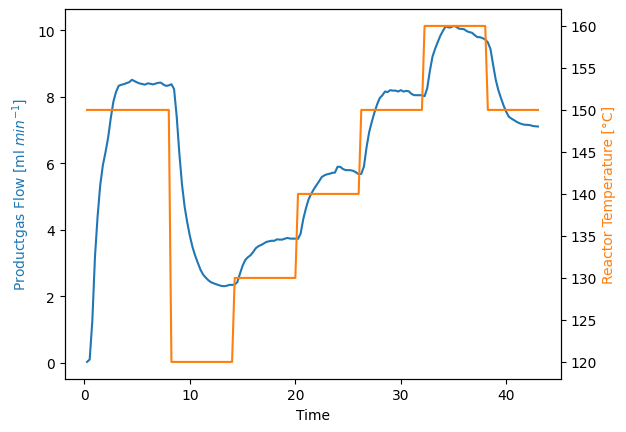

In [ ]:
# @title full data plot experimental

x = default_72['Time']
y1 = default_72['Productgas FlowGasanalyzer']
y2 = default_72['Reactor Temperature']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'tab:blue')
#ax1.plot(default_72_means_array[:, 0], prodFlow_default_72_model, linestyle='', marker = '.', color = 'tab:green', label = 'Flowrate model')
ax2.plot(x, y2, 'tab:orange')

ax1.set_xlabel('Time')
ax1.set_ylabel('Productgas Flow [ml $min^{-1}$]', color = 'tab:blue')
ax2.set_ylabel('Reactor Temperature [°C]', color ='tab:orange')

plt.show()

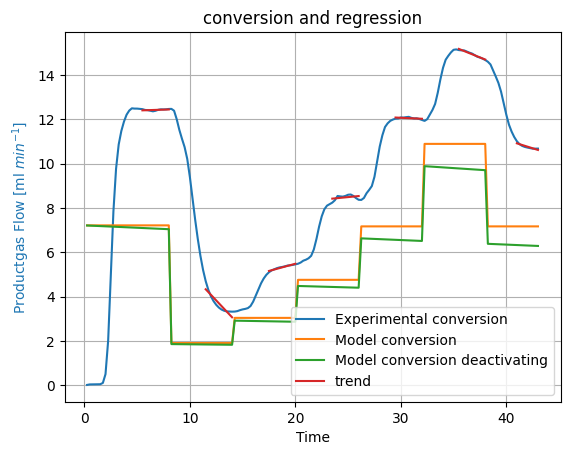

In [ ]:
# @title conversion and regression plot experimental

x = list(default_72['Time'])
y1 = list(default_72['X_{MeOH} [%]'])

x2 = default_72_deactivation_data[:, 1]
y2 = default_72_deactivation_data[:, 0]

plt.figure(1)

plt.plot(x, y1, label='Experimental conversion')
plt.plot(x2, y2, label='Model conversion')
plt.plot(Xt_default[:, 1], Xt_default[:, 0], label='Model conversion deactivating')

plt.plot(default_72_regression_trend[0][0], default_72_regression_trend[0][1], label = 'trend', color = 'tab:red')
for i in range (len(default_72_regression_trend)-1):
    plt.plot(default_72_regression_trend[i+1][0], default_72_regression_trend[i + 1][1], color = 'tab:red')

plt.xlabel('Time')
plt.ylabel('Productgas Flow [ml $min^{-1}$]', color = 'tab:blue')
#plt.axis((0, 40, 4, 14))
plt.title('conversion and regression')
plt.legend(loc='lower right')
plt.grid()


In [ ]:
default_72_deactivation_data

array([[7.21720930e+00, 2.50195278e-01, 4.23000000e+02, 1.03350968e+00],
       [7.21720930e+00, 8.00019972e+00, 4.23000000e+02, 1.03350968e+00],
       [1.91017686e+00, 8.25019972e+00, 3.93000000e+02, 1.03075953e+00],
       [1.91017686e+00, 1.40001997e+01, 3.93000000e+02, 1.03075953e+00],
       [3.04556028e+00, 1.42501997e+01, 4.03000000e+02, 1.02959824e+00],
       [3.04556028e+00, 2.00001997e+01, 4.03000000e+02, 1.02959824e+00],
       [4.76143411e+00, 2.02501997e+01, 4.13000000e+02, 1.02643988e+00],
       [4.76143411e+00, 2.60001997e+01, 4.13000000e+02, 1.02643988e+00],
       [7.17153076e+00, 2.62501997e+01, 4.23000000e+02, 1.00768622e+00],
       [7.17153076e+00, 3.20001997e+01, 4.23000000e+02, 1.00768622e+00],
       [1.08920626e+01, 3.22501997e+01, 4.33000000e+02, 1.00748680e+00],
       [1.08920626e+01, 3.80001997e+01, 4.33000000e+02, 1.00748680e+00],
       [7.17153076e+00, 3.82501997e+01, 4.23000000e+02, 1.00637993e+00],
       [7.17153076e+00, 4.30001997e+01, 4.23000000e

### EXPERIMENTAL DATA 72_02_restart

#### Data manip

In [ ]:
# @title experimental data extraction | simple | for now

molar_volume_ideal_gas = 24210 # [ml mol-1]
V_lN_in_restart_72 = 0.0023 #[lN h^-1]
n_in_restart_72 = 0.08/1000 #[kmol h^-1]


filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/CS_72_02_restart.xlsx'
restart_72 = pd.read_excel(filepath, sheet_name ='Ergebnisse', usecols='B:E, G:I', header = 5)
restart_72 = restart_72.dropna(how='all')
units = restart_72.head(1)
restart_72 = restart_72.drop(0, axis=0)
cat_mass_restart_72 = pd.read_excel(filepath, sheet_name ='Ergebnisse')
cat_mass_restart_72 = cat_mass_restart_72.head(2)['Katalysator']
cat_mass_restart_72 = cat_mass_restart_72[1]/1000
restart_72['group']= (restart_72['Reactor Pressure'].diff()> 0.5).cumsum()
restart_72_molar_fraction_base = restart_72['COppm'] + restart_72['CO2'] + restart_72['H2']
restart_72['CO Flow'] = restart_72['COppm']/restart_72_molar_fraction_base*restart_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
restart_72['CO2 Flow'] = restart_72['CO2']/restart_72_molar_fraction_base*restart_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
restart_72['H2 Flow'] = restart_72['H2']/restart_72_molar_fraction_base*restart_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
restart_72['H2:CO2 ratio'] = restart_72['H2 Flow']/restart_72['CO2 Flow']
restart_72['X_{MeOH} [%]'] = (1 - ((n_in_restart_72/2)*1000-(restart_72['CO2 Flow']+restart_72['CO Flow']))/((n_in_restart_72*1000)/2))*100


criteria = restart_72.groupby('group')['group'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
restart_72_means = restart_72[criteria].groupby('group').mean()
# restart_72_means['n. MeOH in'] = n_in_restart_72/2*1000
# restart_72_means['X_{MeOH} [%]2'] = (1 - (restart_72_means['n. MeOH in']-restart_72_means['CO2 Flow']-restart_72_means['CO Flow'])/restart_72_means['n. MeOH in'])*100

#*((restart_72['Reactor Temperature']+273)/273))
# @title misc calcs

restart_72_means_array = restart_72_means.to_numpy()
compEul_restart_72 = np.zeros([len(restart_72_means_array), len(IC)])

IC_restart_72 = np.array([0, n_in_restart_72/2, 0, 0, n_in_restart_72/2, 0])
prodFlow_restart_72_model = np.zeros([len(restart_72_means_array)])
H2CO2_ratio_restart_72 = np.zeros([len(restart_72_means_array)])
conversion_restart_72_model = np.zeros([len(restart_72_means_array)])

for i in range (len(restart_72_means_array)):
  T_72 = restart_72_means_array[i, 1] + 273
  p_72 = restart_72_means_array[i, 2]
  compEul_restart_72 [i, :] = MainCalcMolFlow(IC_restart_72, T_72, p_72, 0, cat_mass_restart_72)
  prodFlow_restart_72_model [i] = (compEul_restart_72 [i, 0] + compEul_restart_72 [i, 2] + compEul_restart_72 [i, 3]) *molar_volume_ideal_gas/60*1000
  H2CO2_ratio_restart_72 [i] = compEul_restart_72 [i, 0]/compEul_restart_72 [i, 3]
  conversion_restart_72_model [i] = (1-compEul_restart_72 [i, 4]/(n_in_restart_72/2))*100

restart_72_means_production_flow = restart_72_means['Productgas FlowGasanalyzer'].to_numpy()
restart_72_means_methanol_conversion = restart_72_means['X_{MeOH} [%]'].to_numpy()

offset_to_experiment_production_restart_72 = (1 - prodFlow_restart_72_model/restart_72_means_production_flow)*100
offset_to_experiment_conversion_restart_72 = (1 - conversion_restart_72_model/restart_72_means_methanol_conversion)*100

# print('last results entry in each iteration: ', end='\n\n')
# print(compEul_restart_72[:, -1, 4])
# print(n_in_restart_72/2)
# print(H2CO2_ratio_restart_72)
# print(dm_cat_mass_restart_72)
# print(cat_mass_restart_72)

In [ ]:
# @title results table

print(units, end='\n\n\n')
# print('mass catalyst used = ' + str(cat_mass_default_72*1000) + 'g', end='\n\n\n')
print(restart_72_means)

  Time Reactor Temperature Reactor Pressure COppm  CO2   H2 Productgas FlowGasanalyzer
0    h                  °C           barabs   ppm  ppm  ppm                   ml min-1


            Time Reactor Temperature Reactor Pressure       COppm           CO2             H2 Productgas FlowGasanalyzer   CO Flow  CO2 Flow   H2 Flow H2:CO2 ratio X_{MeOH} [%]
group                                                                                                                                                                            
0      14.875226               150.0         1.037813  133.232553  48998.734181  154496.709452                   6.573061  0.000011  0.003918  0.012361     3.154704     9.821975
1      38.250226               150.0          1.93124   90.211045  35781.171924  113739.327625                   5.890517  0.000009  0.003491  0.011098     3.178871     8.750477


In [ ]:
# @title printing

print("prodFlow_restart_72_model", end="\n")
print(prodFlow_restart_72_model, end="\n\n")
print("restart_72_means_production_flow", end="\n")
print(restart_72_means_production_flow, end="\n\n")
print("conversion_restart_72_model", end="\n")
print(conversion_restart_72_model, end="\n\n")
print("restart_72_means_methanol_conversion", end="\n")
print(restart_72_means_methanol_conversion, end="\n\n")
print("offset_to_experiment_production", end="\n")
print(offset_to_experiment_production_restart_72, end="\n\n")
print("offset_to_experiment_conversion", end="\n")
print(offset_to_experiment_conversion_restart_72, end="\n\n")

prodFlow_restart_72_model
[5.48647918 5.48647918]

restart_72_means_production_flow
[6.573060793432983 5.890516615488274]

conversion_restart_72_model
[8.49826395 8.49826395]

restart_72_means_methanol_conversion
[9.82197503120913 8.750476661616933]

offset_to_experiment_production
[16.53083166389786 6.859117176938401]

offset_to_experiment_conversion
[13.477035696833406 2.882273974905014]



In [ ]:
#@title deactivation

restart_72_reg = restart_72[(restart_72['X_{MeOH} [%]'] > 8)]

reg_criteria = restart_72_reg.groupby('group')['group'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
restart_72_reg = restart_72_reg[reg_criteria]

restart_72_deactivation_data = np.zeros((len(restart_72_means) * 2, 4))
for i in range(len(restart_72_means)):
        restart_72_deactivation_data [i*2, :] = (conversion_restart_72_model [i], restart_72[restart_72['group'] == i]['Time'].iat[0], restart_72_means.iat[i, 1] + 273, restart_72_means.iat[i, 2])
        restart_72_deactivation_data [i*2 + 1, :] = (conversion_restart_72_model [i], restart_72[restart_72['group'] == i]['Time'].iat[-1], restart_72_means.iat[i, 1] + 273, restart_72_means.iat[i, 2])

restart_72_regression_fit = np.zeros((len(restart_72_means), 2))
restart_72_regression_trend = {}

regression_array_restart_72 = np.zeros(len(restart_72_means))

x1 = list(restart_72_reg['Time'])

for i in range(len(restart_72_means)):
    x11 = list(restart_72_reg[restart_72_reg['group'] == i]['Time'])
    y11 = list(restart_72_reg[restart_72_reg['group'] == i]['X_{MeOH} [%]'])

    restart_72_regression_fit[i, :] = np.polyfit(x11, y11, deg = 1)
    restart_72_regression_trend [i] = [x11, np.polyval(restart_72_regression_fit[i, :], x11)]

    # for j in range(len(restart_72_reg[restart_72_reg['group'] == i]['Time'])):
    #     restart_72_regression_trend[len(restart_72_reg[restart_72_reg['group'] == i - 1]['Time']) + j] = restart_72_regression_trend_temp[j]

Xt_restart = np.zeros((len(restart_72_deactivation_data), 2))

Xt_restart = DeacFun(restart_72_deactivation_data)

for i in range(len(restart_72_means)):
    regression_array_restart_72[i] = restart_72_regression_fit[i, 0]/conversion_restart_72_model[i]/(restart_72_means_array[i, 1] + 273)/(restart_72_means_array[i, 2]**2.228)

print("regression polyfit: " + str(restart_72_regression_fit[:, 0]))
print("regression array: " + str(regression_array_restart_72))

#for plotting:

# x = list(restart_72['Time'])
# y1 = list(restart_72['X_{MeOH} [%]'])

# x2 = [restart_72_deactivation_data[0, 0], restart_72_deactivation_data[-1, 1]]
# y2 = [conversion_restart_72_model [0],conversion_restart_72_model [1]]

# plt.figure(1)

# plt.plot(x, y1, label='Experimental conversion')
# plt.plot(x2, y2, label='Model conversion')
# plt.plot(Xt_restart[:, 0], Xt_restart[:, 1], label='Model conversion deactivating')
# plt.plot(restart_72_regression_trend[0][0], restart_72_regression_trend[0][1], label = 'trend', color = 'tab:red')
# for i in range (len(restart_72_regression_trend)-1):
#     plt.plot(restart_72_regression_trend[i+1][0], restart_72_regression_trend[1][1], color = 'tab:red')
# plt.xlabel('Time')
# plt.ylabel('Productgas Flow [ml $min^{-1}$]', color = 'tab:blue')
# plt.axis((0, 40, 4, 14))
# plt.title('conversion and regression')
# plt.legend(loc='lower right')
# plt.grid()

# playing around with deactivation value extraction

deactivation_list[1] = regression_array_restart_72

regression polyfit: [-0.00912272 -0.03639614]
regression array: [-2.3363616e-06 -2.3363707e-06]


#### plots

Text(0, 0.5, 'model flowrate [ml min$^{-1}$]')

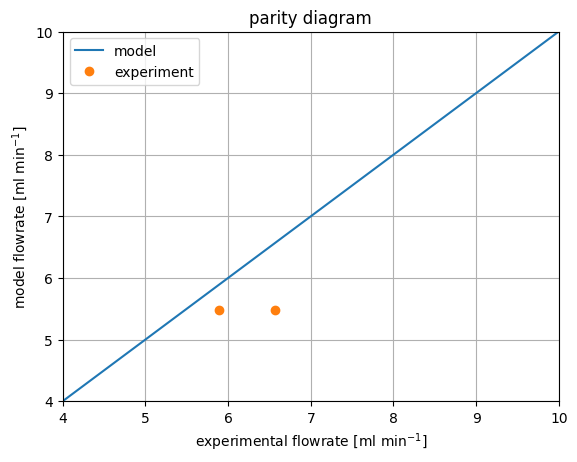

In [ ]:
# @title parity plot flowrates

flow_plot_restart_72 = [4, prodFlow_restart_72_model[0], 10]

plt.figure(1)
plt.plot(flow_plot_restart_72, flow_plot_restart_72, label='model')
plt.plot(restart_72_means_production_flow, prodFlow_restart_72_model, label='experiment', marker='o', linestyle='')
plt.title('parity diagram')
plt.legend(loc='best')
plt.axis((4, 10, 4, 10))
plt.grid()
plt.xlabel("experimental flowrate [ml min$^{-1}$]")
plt.ylabel ("model flowrate [ml min$^{-1}$]")


Text(0, 0.5, 'model conversion [%]')

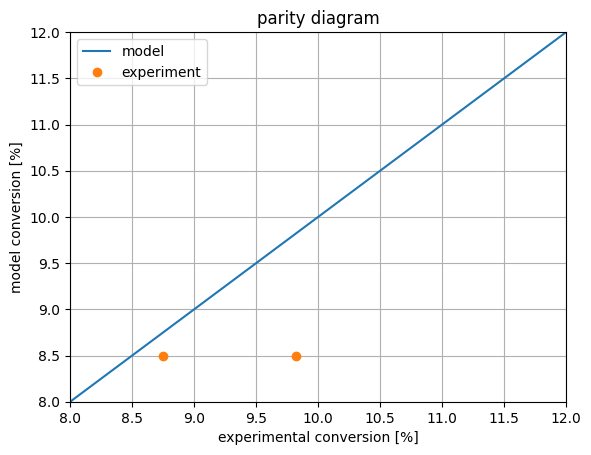

In [ ]:
# @title parity plot conversion

x_plot_restart_72 = [8, prodFlow_restart_72_model[0], 12]

plt.figure(1)
plt.plot(x_plot_restart_72, x_plot_restart_72, label='model')
plt.plot(restart_72_means_methanol_conversion, conversion_restart_72_model, label='experiment', marker='o', linestyle='')
plt.title('parity diagram')
plt.legend(loc='best')
plt.axis((8, 12, 8, 12))
plt.grid()
plt.xlabel("experimental conversion [%]")
plt.ylabel ("model conversion [%]")

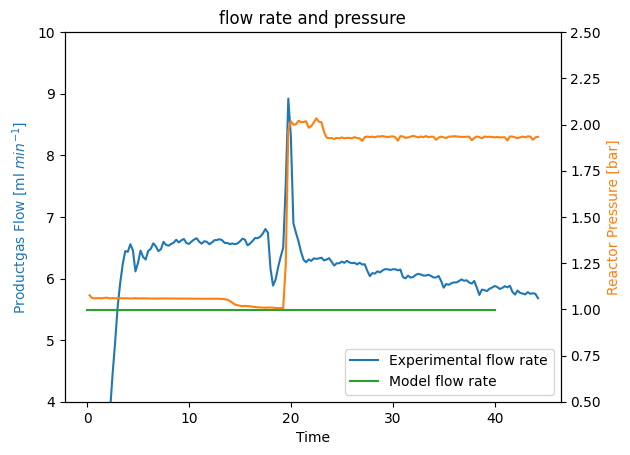

In [ ]:
# @title flow rate and pressure plot experimental

x = restart_72['Time']
y1 = restart_72['Productgas FlowGasanalyzer']
y2 = restart_72['Reactor Pressure']
y3 = [prodFlow_restart_72_model [0],prodFlow_restart_72_model [0]]
y4 = [prodFlow_restart_72_model [1],prodFlow_restart_72_model [1]]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'tab:blue', label='Experimental flow rate')
ax1.plot([0, 20], y3,  'tab:green', label='Model flow rate')
ax1.plot([20, 40], y4,  'tab:green')
ax2.plot(x, y2, 'tab:orange', label='Experimental reactor pressure')
ax1.set(ylim=(4, 10))
ax2.set(ylim=(0.5, 2.5))
ax1.set_xlabel('Time')
ax1.set_ylabel('Productgas Flow [ml $min^{-1}$]', color = 'tab:blue')
ax2.set_ylabel('Reactor Pressure [bar]', color ='tab:orange')

plt.title('flow rate and pressure')
ax1.legend(loc='lower right')

plt.show()


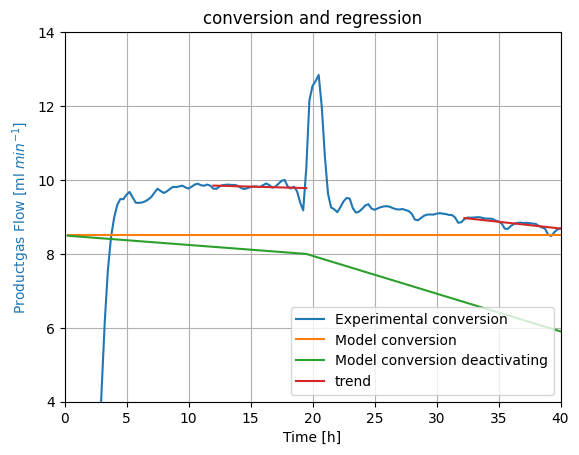

In [ ]:
# @title conversion and regression plot experimental

x = list(restart_72['Time'])
y1 = list(restart_72['X_{MeOH} [%]'])

x2 = [restart_72_deactivation_data[0, 1], restart_72_deactivation_data[-1, 1]]
y2 = [conversion_restart_72_model [0],conversion_restart_72_model [1]]

plt.figure(1)

plt.plot(x, y1, label='Experimental conversion')
plt.plot(x2, y2, label='Model conversion')
plt.plot(Xt_restart[:, 1], Xt_restart[:, 0], label='Model conversion deactivating')

plt.plot(restart_72_regression_trend[0][0], restart_72_regression_trend[0][1], label = 'trend', color = 'tab:red')
for i in range (len(restart_72_regression_trend)-1):
    plt.plot(restart_72_regression_trend[i+1][0], restart_72_regression_trend[1][1], color = 'tab:red')

plt.xlabel('Time [h]')
plt.ylabel('Productgas Flow [ml $min^{-1}$]', color = 'tab:blue')
plt.axis((0, 40, 4, 14))
plt.title('conversion and regression')
plt.legend(loc='lower right')
plt.grid()


### EXPERIMENTAL DATA 72_02_pVar


#### Data manip

In [ ]:
# @title experimental data extraction | simple | for now

molar_volume_ideal_gas = 24210 # [ml mol-1]
V_lN_in_pVar_72 = 0.0023 #[lN h^-1]
n_in_pVar_72 = 0.08/1000 #[kmol h^-1]
n_in_pVar_72_array = np.array([[7.24*10**(-7)*60, 1.06*10**(-6)*60, 1.43*10**(-6)*60, 7.24*10**(-7)*60, 3.70*10**(-7)*60, 7.24*10**(-7)*60, 6.92*10**(-7)*60, 7.16*10**(-7)*60,
                                7.24*10**(-7)*60, 7.36*10**(-7)*60],[6.79*10**(-7)*60, 7.07*10**(-7)*60, 6.70*10**(-7)*60, 6.79*10**(-7)*60, 6.97*10**(-7)*60,
                                6.79*10**(-7)*60, 9.98*10**(-7)*60, 1.34*10**(-6)*60, 6.79*10**(-7)*60, 3.53*10**(-7)*60]])
#, 7.24*10**(-7)*60 | , 6.79*10**(-7)*60

filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/CS_72_02_pVar.xlsx'
pVar_72 = pd.read_excel(filepath, sheet_name ='Mittelung', usecols='C:F, H:J', header = 2)
pVar_72 = pVar_72.dropna(how='all')
units = pVar_72.head(1)
pVar_72 = pVar_72.drop(0, axis=0)
pVar_72 = pVar_72.drop(index=pVar_72.index[-2:])
pVar_72['Starttime'] = pVar_72['Starttime'].fillna(0)
cat_mass_pVar_72 = pd.read_excel(filepath, sheet_name ='Ergebnisse')
cat_mass_pVar_72 = cat_mass_pVar_72.head(2)['Katalysator']
cat_mass_pVar_72 = cat_mass_pVar_72[1]/1000
# pVar_72['group']= (pVar_72['Reactor Pressure'].diff()> 0.2).cumsum()
pVar_72_molar_fraction_base = pVar_72['COppm'] + pVar_72['CO2'] + pVar_72['H2']
pVar_72['CO Flow'] = pVar_72['COppm']/pVar_72_molar_fraction_base*pVar_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
pVar_72['CO2 Flow'] = pVar_72['CO2']/pVar_72_molar_fraction_base*pVar_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
pVar_72['H2 Flow'] = pVar_72['H2']/pVar_72_molar_fraction_base*pVar_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
pVar_72['H2:CO2 ratio'] = pVar_72['H2 Flow']/pVar_72['CO2 Flow']
pVar_72['n_{MeOH}'] = n_in_pVar_72_array[0, :]#(1 - ((n_in_pVar_72/2)*1000-(pVar_72['CO2 Flow']+pVar_72['CO Flow']))/((n_in_pVar_72*1000)/2))*100
pVar_72['n_{H2O}'] = n_in_pVar_72_array[1, :]
pVar_72['X [%]'] = np.where(pVar_72['n_{MeOH}'] < pVar_72['n_{H2O}'], (1 - ((pVar_72['n_{MeOH}']*1000)-(pVar_72['CO2 Flow']+pVar_72['CO Flow']))/(pVar_72['n_{MeOH}']*1000))*100,
                    (1 - ((pVar_72['n_{H2O}']*1000)-(pVar_72['CO2 Flow']+pVar_72['CO Flow']))/(pVar_72['n_{H2O}']*1000))*100)
#criteria = pVar_72.groupby('group')['group'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
#pVar_72_means = pVar_72[criteria].groupby('group').mean()

pVar_72_means = pVar_72.copy()

# pVar_72['X_{MeOH} [%] Average'] = pVar_72['X_{MeOH} [%]'].rolling(25).mean()

# pVar_72_means['n. MeOH in'] = n_in_pVar_72/2*1000
# pVar_72_means['X_{MeOH} [%]2'] = (1 - (pVar_72_means['n. MeOH in']-pVar_72_means['CO2 Flow']-pVar_72_means['CO Flow'])/pVar_72_means['n. MeOH in'])*100

#*((pVar_72['Reactor Temperature']+273)/273))
# @title misc calcs

pVar_72_means_array = pVar_72_means.to_numpy()

compEul_pVar_72 = np.zeros([len(pVar_72_means_array), len(IC)])

prodFlow_pVar_72_model = np.zeros([len(pVar_72_means_array)])
H2CO2_ratio_pVar_72 = np.zeros([len(pVar_72_means_array)])
conversion_pVar_72_model = np.zeros([len(pVar_72_means_array)])

for i in range (len(pVar_72_means_array)):
  T_72 = pVar_72_means_array[i, 1] + 273
  p_72 = pVar_72_means_array[i, 2]
  IC_pVar_72 = np.array([0, n_in_pVar_72_array[1, i], 0, 0, n_in_pVar_72_array[0, i], 0])
  compEul_pVar_72 [i, :] = MainCalcMolFlow(IC_pVar_72, T_72, p_72, 0, cat_mass_pVar_72)
  prodFlow_pVar_72_model [i] = (compEul_pVar_72 [i, 0] + compEul_pVar_72 [i, 2] + compEul_pVar_72 [i, 3]) *molar_volume_ideal_gas/60*1000
  H2CO2_ratio_pVar_72[i] = compEul_pVar_72 [i, 0]/compEul_pVar_72 [i, 3]
  if n_in_pVar_72_array[0, i] < n_in_pVar_72_array[1, i]:
    conversion_pVar_72_model [i] = (1-compEul_pVar_72 [i, 4]/(n_in_pVar_72_array[0, i]))*100
  else:
    conversion_pVar_72_model [i] = (1-compEul_pVar_72 [i, 1]/(n_in_pVar_72_array[1, i]))*100

pVar_72_means_production_flow = pVar_72_means['Productgas FlowGasanalyzer'].to_numpy()
pVar_72_means_methanol_conversion = pVar_72_means['X [%]'].to_numpy()

offset_to_experiment_production_pVar_72 = (1 - prodFlow_pVar_72_model/pVar_72_means_production_flow)*100
offset_to_experiment_conversion_pVar_72 = (1 - conversion_pVar_72_model/pVar_72_means_methanol_conversion)*100

# print('last results entry in each iteration: ', end='\n\n')
# print(compEul_pVar_72[:, -1, 4])
# print(n_in_pVar_72/2)
# print(H2CO2_ratio_pVar_72)
# print(dm_cat_mass_pVar_72)
# print(cat_mass_pVar_72)

In [ ]:
# @title results table

print(units, end='\n\n\n')
# print('mass catalyst used = ' + str(cat_mass_default_72*1000) + 'g', end='\n\n\n')
print(pVar_72_means)

  Starttime Reactor Temperature Reactor Pressure COppm  CO2   H2 Productgas FlowGasanalyzer
0         h                  °C           barabs   ppm  ppm  ppm                   ml min-1


    Starttime Reactor Temperature Reactor Pressure       COppm           CO2             H2 Productgas FlowGasanalyzer   CO Flow  CO2 Flow   H2 Flow H2:CO2 ratio  n_{MeOH}   n_{H2O}      X [%]
1     0.00000                 150         1.931012   84.115641  35248.953641  111204.042016                   5.748461  0.000008  0.003427  0.010811     3.154818  0.000043  0.000041   8.431809
2     7.00023                 150         1.944863  132.436464  50582.989819  159614.771988                   6.664153   0.00001  0.003972  0.012534     3.155503  0.000064  0.000042   9.387916
3    15.00023                 150         1.984383     252.528  74408.725387  229497.143661                   7.548937  0.000016  0.004577  0.014116     3.084277  0.000086  0.000040  11.423829
4    21.00023                 150         

In [ ]:
# @title printing

print("prodFlow_pVar_72_model", end="\n")
print(prodFlow_pVar_72_model, end="\n\n")
print("pVar_72_means_production_flow", end="\n")
print(pVar_72_means_production_flow, end="\n\n")
print("conversion_pVar_72_model", end="\n")
print(conversion_pVar_72_model, end="\n\n")
print("pVar_72_means_methanol_conversion", end="\n")
print(pVar_72_means_methanol_conversion, end="\n\n")
print("offset_to_experiment_production", end="\n")
print(offset_to_experiment_production_pVar_72, end="\n\n")
print("offset_to_experiment_conversion", end="\n")
print(offset_to_experiment_conversion_pVar_72, end="\n\n")

prodFlow_pVar_72_model
[5.48083497 5.26751653 4.76788727 5.48083497 4.97117888 5.48083497
 5.30660734 4.98110077 5.48083497 4.80784533]

pVar_72_means_production_flow
[5.748461099794503 6.6641529663233925 7.548937252858675 5.19338390161743
 3.4111992437222596 4.456202274884813 4.348001527897706 3.989450366270538
 4.0622503833652495 3.784216221136462]

conversion_pVar_72_model
[ 8.33531781  7.69363725  7.34846089  8.33531781 13.87403827  8.33531781
  7.91873994  7.18385448  8.33531781 14.06439303]

pVar_72_means_methanol_conversion
[8.43180923056278 9.387916170765564 11.423828879201881 7.6173579642305755
 8.933954954016787 6.417472322563089 6.185963583023701 5.57968961621259
 5.74271805083022 10.175076802022787]

offset_to_experiment_production
[4.655613561547833 20.95744867948339 36.84028482066881 -5.534947330683848
 -45.73112044605967 -22.993406204700186 -22.047044059660937
 -24.85681755424187 -34.92115079109761 -27.049963565769588]

offset_to_experiment_conversion
[1.1443738172089435

#### plots

Text(0, 0.5, 'model flowrate [ml min$^{-1}$]')

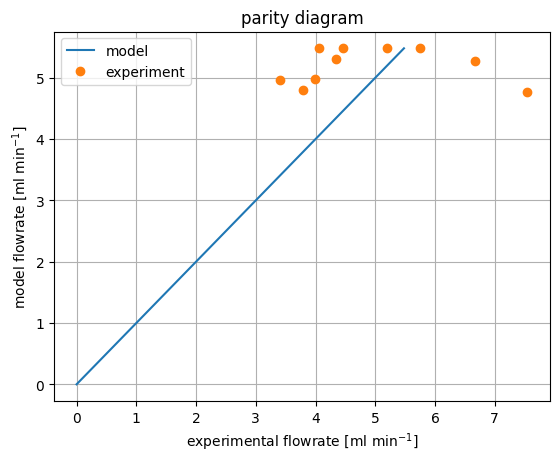

In [ ]:
# @title parity plot flowrates

flowrate_model_plot = [0, prodFlow_pVar_72_model[0]]

plt.figure(1)
plt.plot(flowrate_model_plot, flowrate_model_plot, label='model')
plt.plot(pVar_72_means_production_flow, prodFlow_pVar_72_model, label='experiment', marker='o', linestyle='')
plt.title('parity diagram')
plt.legend(loc='best')
#plt.axis((2, 7, 2, 8))
plt.grid()
plt.xlabel("experimental flowrate [ml min$^{-1}$]")
plt.ylabel ("model flowrate [ml min$^{-1}$]")

Text(0, 0.5, 'model conversion [%]')

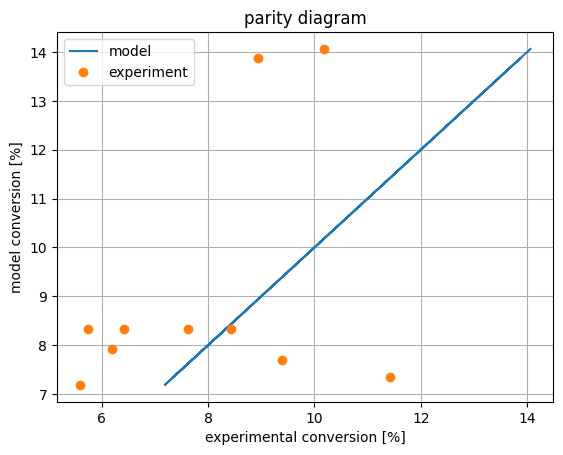

In [ ]:
# @title parity plot conversion

plt.figure(1)
plt.plot(conversion_pVar_72_model, conversion_pVar_72_model, label='model')
plt.plot(pVar_72_means_methanol_conversion, conversion_pVar_72_model, label='experiment', marker='o', linestyle='')
plt.title('parity diagram')
plt.legend(loc='best')
#plt.axis((2, 20, 12, 16))
plt.grid()
plt.xlabel("experimental conversion [%]")
plt.ylabel ("model conversion [%]")

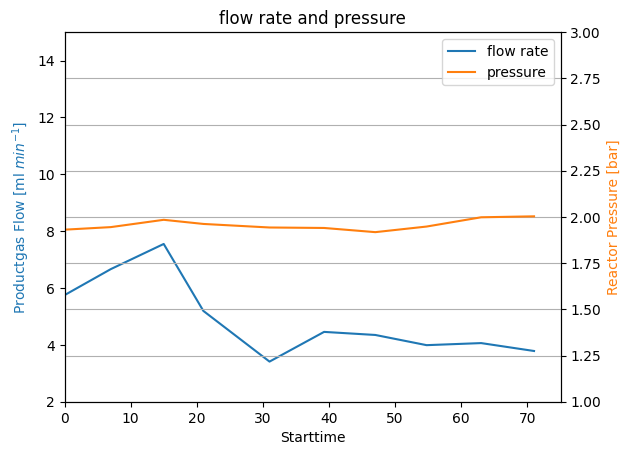

In [ ]:
# @title flow rate and pressure plot experimental

x = pVar_72['Starttime']
y1 = pVar_72['Productgas FlowGasanalyzer']
y2 = pVar_72['Reactor Pressure']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'tab:blue', label='flow rate')
ax2.plot(x, y2, 'tab:orange', label='pressure')

ax1.set_xlabel('Starttime')
ax1.set_ylabel('Productgas Flow [ml $min^{-1}$]', color = 'tab:blue')
ax2.set_ylabel('Reactor Pressure [bar]', color ='tab:orange')
ax1.axis((0, 75, 2, 15))
ax2.axis((0, 75, 1, 3))
plt.title('flow rate and pressure')
plt.legend(loc='best')
plt.grid()


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

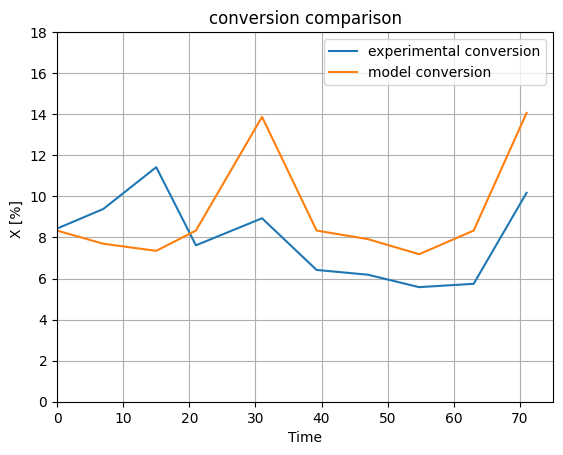

In [ ]:
# @title conversion and pressure plot experimental

# old data plotting with "Auswertung" instead of "Ergebnisse"

# reg_val_cutoff = 75

# x = list(pVar_72['Time'])
# x1 = list(pVar_72['Time'][:reg_val_cutoff])
# x11 = list(pVar_72['Time'][reg_val_cutoff:])
# y1 = list(pVar_72['X_{MeOH} [%]'])
# y3 = list(pVar_72['X_{MeOH} [%]'][:reg_val_cutoff])
# y31 = list(pVar_72['X_{MeOH} [%]'][reg_val_cutoff:])
# y2 = list(pVar_72['Reactor Pressure'])

# reg1 = np.polyfit(x1, y3, deg = 1)
# trend1 = np.polyval(reg1, x1)

# reg11 = np.polyfit(x11, y31, deg = 1)
# trend11 = np.polyval(reg11, x11)

# fig, ax1 = plt.subplots()

# ax2 = ax1.twinx()
# ax1.plot(x, y1, 'tab:blue', label = 'conversion')
# #ax1.plot(x, y3, 'tab:green')
# ax1.plot(x1, trend1, 'tab:green', label = 'regression')
# ax1.plot(x11, trend11, 'tab:green')
# ax2.plot(x, y2, 'tab:orange', label = 'pressure')

# ax1.set_xlabel('Time')
# ax1.set_ylabel('$X_{MeOH}$ [%]', color = 'tab:blue')
# ax2.set_ylabel('Reactor Pressure [bar]', color ='tab:orange')
# ax1.axis((0, 120, 2, 22))
# ax2.axis((0, 120, 1, 3))
# plt.title('conversion and pressure')

# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='best')

# plt.grid()

# plt.show()

x = pVar_72['Starttime']
y1 = pVar_72['X [%]']
y2 = conversion_pVar_72_model

plt.figure(1)

plt.plot(x, y1, label = 'experimental conversion')
plt.plot(x, y2, label = 'model conversion')
plt.xlabel('Time')
plt.ylabel('X [%] ')
plt.axis((0, 75, 0, 18))
plt.title('conversion comparison')

plt.legend(loc='best')
plt.grid()

plt.show()

## Experimental Data Aziz

### MSR 002

#### Data manip

In [ ]:
#@title experimental data extraction | simple

molar_volume_ideal_gas = 24210 # [ml mol-1]
V_lN_in_Aziz_MSR_002 = 0.0023 #[lN h^-1]

filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/#2 Validation_DN - Calculation MSR - 20220428_MSR_002 - 5g 1to2.xlsm'
Aziz_MSR_002 = pd.read_excel(filepath, sheet_name ='Calculated data', usecols='D:G, I:M, O:P', header = 5)
Aziz_MSR_002 = Aziz_MSR_002.dropna(how='all')
Aziz_MSR_002 = Aziz_MSR_002.drop(0, axis=0)
#Aziz_MSR_002 = Aziz_MSR_002.drop(index=Aziz_MSR_002.index[-2:])

cat_mass_Aziz_MSR_002 = pd.read_excel(filepath, sheet_name ='Calculated data', index_col=None, usecols = "F", header = 0, nrows=0)
cat_mass_Aziz_MSR_002 = cat_mass_Aziz_MSR_002.columns.values[0]/1000

n_in_Aziz_MSR_002 = pd.read_excel(filepath, sheet_name ='results', index_col=None, usecols = "D", header = 0, nrows=8)
n_in_Aziz_MSR_002_MeOH = n_in_Aziz_MSR_002.iat[5, 0]/1000*1/3 #mol/h -> kmol/h
n_in_Aziz_MSR_002_H2O = n_in_Aziz_MSR_002.iat[5, 0]/1000*2/3

index_names_temp = Aziz_MSR_002[ Aziz_MSR_002['Reactor Temperature (°C)'] > 152 ].index
Aziz_MSR_002.drop(index_names_temp, inplace = True)

Aziz_MSR_002_dropped = Aziz_MSR_002.copy()
Aziz_MSR_002_dropped['Conversion % mean'] = Aziz_MSR_002_dropped['Conversion %'].rolling(25).mean()
Aziz_MSR_002_dropped['Conversion % smoothed'] = (Aziz_MSR_002_dropped['Conversion %'] - Aziz_MSR_002_dropped['Conversion % mean']).abs()

Aziz_MSR_002_dropped.loc[(Aziz_MSR_002_dropped['Conversion % smoothed'].diff(7) > 0.2) & (Aziz_MSR_002_dropped['Conversion % smoothed'].diff(-7) > 0.2) , 'diff group'] = 1
Aziz_MSR_002_dropped.loc[(Aziz_MSR_002_dropped['Conversion % smoothed'].diff(7) < 0.2) & (Aziz_MSR_002_dropped['Conversion % smoothed'].diff(-7) < 0.2) , 'diff group'] = 0
Aziz_MSR_002_dropped = Aziz_MSR_002_dropped[Aziz_MSR_002_dropped['diff group'] == 0]
Aziz_MSR_002_dropped['Conversion % mean2'] = Aziz_MSR_002_dropped['Conversion %'].rolling(25).mean().shift(-10)

Aziz_MSR_002['tempdiff'] = Aziz_MSR_002['Reactor Temperature (°C)'].diff(10).abs()
Aziz_MSR_002 = Aziz_MSR_002[Aziz_MSR_002['Conversion %'] > 5]
max_temp_diff = Aziz_MSR_002['tempdiff'].max()
max_temp_diff_location = Aziz_MSR_002.loc[Aziz_MSR_002['tempdiff'] == max_temp_diff]

Aziz_MSR_002['groups'] = (Aziz_MSR_002['tempdiff'] - max_temp_diff == 0).cumsum()

criteria = Aziz_MSR_002.groupby('groups')['groups'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
Aziz_MSR_002_means = Aziz_MSR_002[criteria].groupby('groups').mean()

# # @title misc calcs

Aziz_MSR_002_means_array = Aziz_MSR_002_means.to_numpy()

compEul_Aziz_MSR_002 = np.zeros([len(Aziz_MSR_002_means_array), len(IC)])

IC_Aziz_MSR_002 = np.array([0, n_in_Aziz_MSR_002_H2O, 0, 0, n_in_Aziz_MSR_002_MeOH, 0])
prodFlow_Aziz_MSR_002_model = np.zeros([len(Aziz_MSR_002_means_array)])
H2CO2_ratio_Aziz_MSR_002 = np.zeros([len(Aziz_MSR_002_means_array)])
conversion_Aziz_MSR_002_model = np.zeros([len(Aziz_MSR_002_means_array)])

for i in range (len(Aziz_MSR_002_means_array)):

  T_Aziz = Aziz_MSR_002_means_array[i, 9] + 273
  p_Aziz = Aziz_MSR_002_means_array[i, 10]

  compEul_Aziz_MSR_002 [i, :] = MainCalcMolFlow(IC_Aziz_MSR_002, T_Aziz, p_Aziz, 0, cat_mass_Aziz_MSR_002)
  prodFlow_Aziz_MSR_002_model [i] = (compEul_Aziz_MSR_002 [i, 0] + compEul_Aziz_MSR_002 [i, 2] + compEul_Aziz_MSR_002 [i, 3]) *molar_volume_ideal_gas/60*1000
  H2CO2_ratio_Aziz_MSR_002[i] = compEul_Aziz_MSR_002 [i, 0]/compEul_Aziz_MSR_002 [i, 3]
  if n_in_Aziz_MSR_002_MeOH < n_in_Aziz_MSR_002_H2O:
    conversion_Aziz_MSR_002_model [i] = (1-compEul_Aziz_MSR_002 [i, 4]/(n_in_Aziz_MSR_002_MeOH))*100
  else:
    conversion_Aziz_MSR_002_model [i] = (1-compEul_Aziz_MSR_002 [i, 1]/(n_in_Aziz_MSR_002_H2O))*100

Aziz_MSR_002_means_production_flow = Aziz_MSR_002_means['Total H2 and CO2 volumetric flowrate (ml/min)'].to_numpy()
Aziz_MSR_002_means_methanol_conversion = Aziz_MSR_002_means['Conversion %'].to_numpy()

offset_to_experiment_production_Aziz_MSR_002 = (1 - prodFlow_Aziz_MSR_002_model/Aziz_MSR_002_means_production_flow)*100
offset_to_experiment_conversion_Aziz_MSR_002 = (1 - conversion_Aziz_MSR_002_model/Aziz_MSR_002_means_methanol_conversion)*100

print('last results entry in each iteration: ', end='\n\n')
print(compEul_Aziz_MSR_002[:, 4])
# print(n_in_Aziz_MSR_002/2)
# print(H2CO2_ratio_Aziz_MSR_002)
# print(dm_cat_mass_Aziz_MSR_002)
# print(cat_mass_Aziz_MSR_002)

last results entry in each iteration: 

[2.40373004e-05 2.44964052e-05]


In [ ]:
# @title testing
# Aziz_MSR_002
# n_in_Aziz_MSR_002
# n_in_Aziz_MSR_002_MeOH
# max_temp_diff
Aziz_MSR_002_means

,Time (s),Time (h),CO outlet concentration (vol%),CO2 outlet concentration (vol%),H2 outlet concentration (vol%),Calc. N2 concentration (vol%),Total product volumetric flowrate (ml/min),Total H2 and CO2 volumetric flowrate (ml/min),Conversion %,Reactor Temperature (°C),Reactor Pressure (bar),tempdiff
groups,,,,,,,,,,,,
0,18090.0,5.025000,-0.057357,2.581717,7.484660,88.843177,33.769315,3.428199,8.491247,149.889299,1.055351,0.151734
1,62265.0,17.295833,-0.059187,2.061123,6.027763,90.955792,32.983977,2.695282,6.675897,145.000067,1.055719,0.024888


In [ ]:
# @title printing results

print(Aziz_MSR_002_means_production_flow)
print(prodFlow_Aziz_MSR_002_model)
print(Aziz_MSR_002_means_methanol_conversion)
print(conversion_Aziz_MSR_002_model)
print(offset_to_experiment_production_Aziz_MSR_002)
print(offset_to_experiment_conversion_Aziz_MSR_002)
# print(Aziz_MSR_002_means_array)


[3.42819933 2.69528201]
[4.24379711 3.50280204]
[8.49124669 6.67589665]
[9.86012345 8.1384806 ]
[-23.79085056 -29.96050243]
[-16.12103396 -21.90842722]


In [ ]:
#@title deactivation

Aziz_MSR_002_reg = Aziz_MSR_002_dropped[(Aziz_MSR_002_dropped['Conversion %'] > 5)]

Aziz_MSR_002_reg['tempdiff'] = Aziz_MSR_002_reg['Reactor Temperature (°C)'].diff(10).abs()
max_temp_diff = Aziz_MSR_002_reg['tempdiff'].max()
max_temp_diff_location = Aziz_MSR_002_reg.loc[Aziz_MSR_002_reg['tempdiff'] == max_temp_diff]

Aziz_MSR_002_reg['groups'] = (Aziz_MSR_002_reg['tempdiff'] - max_temp_diff == 0).cumsum()

reg_criteria = Aziz_MSR_002_reg.groupby('groups')['groups'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
Aziz_MSR_002_reg = Aziz_MSR_002_reg[reg_criteria]

Aziz_MSR_002_deactivation_data = np.zeros((len(Aziz_MSR_002_means) * 2, 4))

for i in range(len(Aziz_MSR_002_means)):
        Aziz_MSR_002_deactivation_data [i*2, :] = (conversion_Aziz_MSR_002_model [i], Aziz_MSR_002[Aziz_MSR_002['groups'] == i]['Time (h)'].iat[0], Aziz_MSR_002_means.iat[i, 9] + 273, Aziz_MSR_002_means.iat[i, 10])
        Aziz_MSR_002_deactivation_data [i*2 + 1, :] = (conversion_Aziz_MSR_002_model [i], Aziz_MSR_002[Aziz_MSR_002['groups'] == i]['Time (h)'].iat[-1], Aziz_MSR_002_means.iat[i, 9] + 273, Aziz_MSR_002_means.iat[i, 10])

Aziz_MSR_002_regression_fit = np.zeros((len(Aziz_MSR_002_means), 2))
Aziz_MSR_002_regression_trend = {}

regression_array_Aziz_MSR_002 = np.zeros(len(Aziz_MSR_002_means))

x1 = list(Aziz_MSR_002_reg['Time (h)'])

for i in range(len(Aziz_MSR_002_means)):
    x11 = list(Aziz_MSR_002_reg[Aziz_MSR_002_reg['groups'] == i]['Time (h)'])
    y11 = list(Aziz_MSR_002_reg[Aziz_MSR_002_reg['groups'] == i]['Conversion %'])

    Aziz_MSR_002_regression_fit[i, :] = np.polyfit(x11, y11, deg = 1)
    Aziz_MSR_002_regression_trend [i] = [x11, np.polyval(Aziz_MSR_002_regression_fit[i, :], x11)]

    # for j in range(len(Aziz_MSR_002_reg[Aziz_MSR_002_reg['group'] == i]['Time (h)'])):
    #     Aziz_MSR_002_regression_trend[len(Aziz_MSR_002_reg[Aziz_MSR_002_reg['group'] == i - 1]['Time (h)']) + j] = Aziz_MSR_002_regression_trend_temp[j]

Xt_002 = np.zeros((len(Aziz_MSR_002_deactivation_data), 2))

Xt_002 = DeacFun(Aziz_MSR_002_deactivation_data)

for i in range(len(Aziz_MSR_002_means)):
    regression_array_Aziz_MSR_002[i] = Aziz_MSR_002_regression_fit[i, 0]/conversion_Aziz_MSR_002_model[i]/(Aziz_MSR_002_means_array[i, 9] + 273)/(Aziz_MSR_002_means_array[i, 10]**2.228)

print("regression polyfit: " + str(Aziz_MSR_002_regression_fit[:, 0]))
print("regression array: " + str(regression_array_Aziz_MSR_002))

# playing around with deactivation value extraction

deactivation_list[2] = regression_array_Aziz_MSR_002

regression polyfit: [ 0.17131104 -0.01536191]
regression array: [ 3.64374611e-05 -4.00184147e-06]


In [ ]:
# @title creating model plotting array

timeslots_Aziz_MSR_002 = Aziz_MSR_002.groupby('groups')['Time (h)'].agg(['first','last']).to_numpy()

timeslots_Aziz_MSR_002
conversion_Aziz_MSR_002_model
conversion_Aziz_MSR_002_model_over_time = np.zeros([len(conversion_Aziz_MSR_002_model)*2, 2])


for j in range(len(conversion_Aziz_MSR_002_model)):
  conversion_Aziz_MSR_002_model_over_time[j*2, 1] = conversion_Aziz_MSR_002_model[j]
  conversion_Aziz_MSR_002_model_over_time[j*2+1, 1] = conversion_Aziz_MSR_002_model[j]
  conversion_Aziz_MSR_002_model_over_time [j*2, 0] = timeslots_Aziz_MSR_002[j, 0]
  conversion_Aziz_MSR_002_model_over_time [j*2+1, 0] = timeslots_Aziz_MSR_002[j, 1]

#conversion_Aziz_MSR_002_model_over_time

#### plots

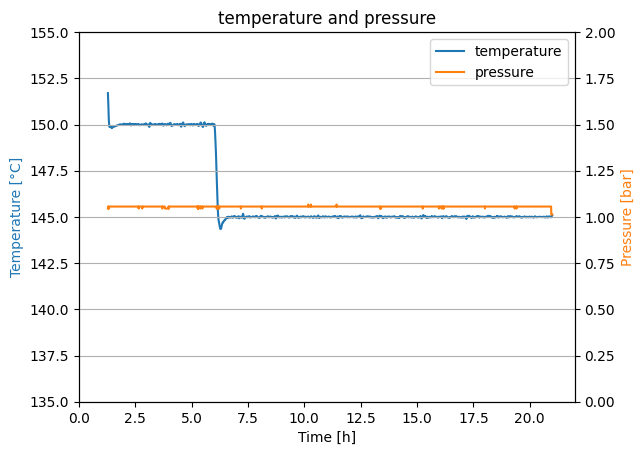

In [ ]:
# @title temperature and pressure

x = Aziz_MSR_002['Time (h)']
y1 = Aziz_MSR_002['Reactor Temperature (°C)']
y3 = Aziz_MSR_002['Reactor Pressure (bar)']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'tab:blue', label='temperature')
ax2.plot(x, y3, 'tab:orange', label='pressure')

ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Temperature [°C]', color = 'tab:blue')
ax2.set_ylabel('Pressure [bar]', color ='tab:orange')
ax1.axis((0, 22, 135, 155))
ax2.axis((0, 22, 0, 2))
plt.title('temperature and pressure')
plt.legend(loc='best')
plt.grid()


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

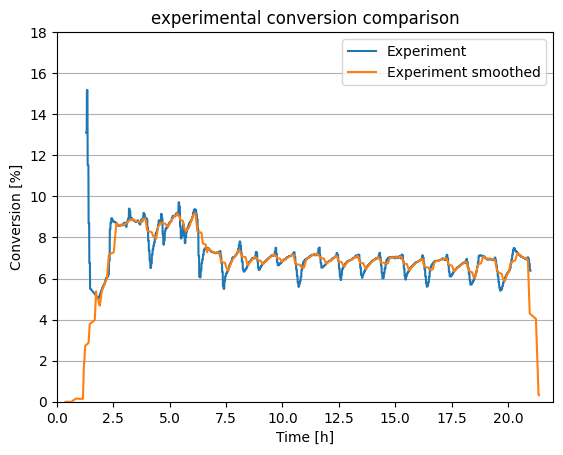

In [ ]:
# @title conversion smoothed comparison

x1 = Aziz_MSR_002['Time (h)']
y1 = Aziz_MSR_002['Conversion %']
x2 = Aziz_MSR_002_dropped['Time (h)']
y2 = Aziz_MSR_002_dropped['Conversion % mean2']

plt.figure(1)

plt.plot(x1, y1, label='Experiment')
plt.plot(x2, y2, label='Experiment smoothed')
#plt.plot(conversion_Aziz_MSR_006_model_over_time[:, 0], conversion_Aziz_MSR_006_model_over_time[:, 1], label='Model')
plt.xlabel("Time [h]")
plt.ylabel("Conversion [%]")
plt.title('experimental conversion comparison')
plt.axis((0, 22, 0, 18))
plt.legend(loc='best')

plt.grid(axis='y')

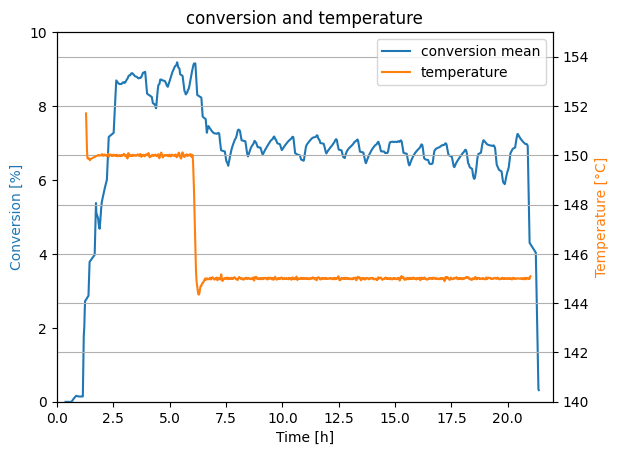

In [ ]:
# @title temperature and conversion experimental

x1 = Aziz_MSR_002['Time (h)']
x2 = Aziz_MSR_002_dropped['Time (h)']
y1 = Aziz_MSR_002_dropped['Conversion % mean2']
y2 = Aziz_MSR_002['Reactor Temperature (°C)']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x2, y1, 'tab:blue', label='conversion mean')
ax2.plot(x1, y2, 'tab:orange', label='temperature')

ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Conversion [%]', color ='tab:blue')
ax2.set_ylabel('Temperature [°C]', color ='tab:orange')
ax1.axis((0, 22, 0, 10))
ax2.axis((0, 22, 140, 155))
plt.title('conversion and temperature')
plt.legend(loc='best')
plt.grid()


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

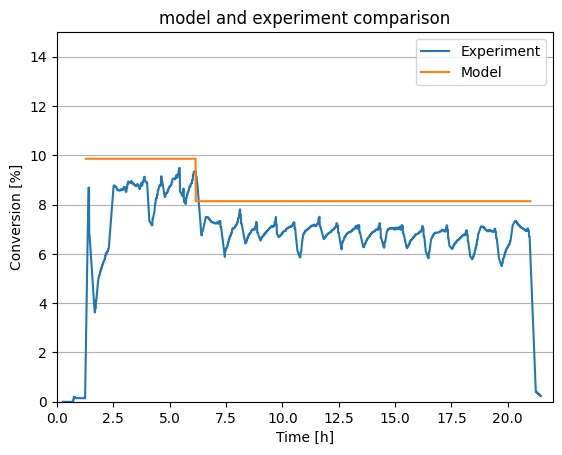

In [ ]:
# @title conversion comparison

x = Aziz_MSR_002_dropped['Time (h)']
y = Aziz_MSR_002_dropped['Conversion %']

plt.figure(1)

plt.plot(x, y, label='Experiment')
plt.plot(conversion_Aziz_MSR_002_model_over_time[:, 0], conversion_Aziz_MSR_002_model_over_time[:, 1], label='Model')
plt.xlabel("Time [h]")
plt.ylabel("Conversion [%]")
plt.title('model and experiment comparison')
plt.axis((0, 22, 0, 15))
plt.legend(loc='best')

plt.grid(axis='y')

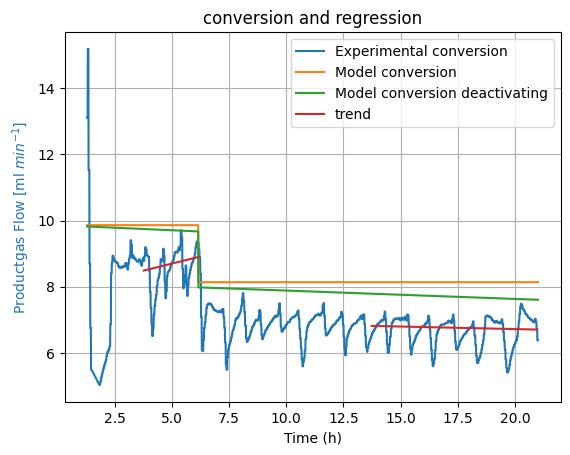

In [ ]:
#@title conversion and regression plot experimental

x002 = list(Aziz_MSR_002['Time (h)'])
y002 = list(Aziz_MSR_002['Conversion %'])

x0022 = Aziz_MSR_002_deactivation_data[:, 1]
y0022 = Aziz_MSR_002_deactivation_data[:, 0]

plt.figure(1)

plt.plot(x002, y002, label='Experimental conversion')
plt.plot(x0022, y0022, label='Model conversion')
plt.plot(Xt_002[:, 1], Xt_002[:, 0], label='Model conversion deactivating')

plt.plot(Aziz_MSR_002_regression_trend[0][0], Aziz_MSR_002_regression_trend[0][1], label = 'trend', color = 'tab:red')
for i in range (len(Aziz_MSR_002_regression_trend)-1):
    plt.plot(Aziz_MSR_002_regression_trend[i+1][0], Aziz_MSR_002_regression_trend[i+1][1], color = 'tab:red')

plt.xlabel('Time (h)')
plt.ylabel('Productgas Flow [ml $min^{-1}$]', color = 'tab:blue')
#plt.axis((0, 40, 4, 14))
plt.title('conversion and regression')
plt.legend(loc='best')
plt.grid()


### MSR 003

#### Data manip

In [ ]:
# @title experimental data extraction | simple

molar_volume_ideal_gas = 24210 # [ml mol-1]
V_lN_in_Aziz_MSR_003 = 0.0023 #[lN h^-1]

filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/#2 Validation_DN - Calculation MSR - 20220429_MSR_003 - 5g 2to1.xlsx'
Aziz_MSR_003 = pd.read_excel(filepath, sheet_name ='Calculated data', usecols='D:G, I:M, O:P', header = 5)
Aziz_MSR_003 = Aziz_MSR_003.dropna(how='all')
Aziz_MSR_003 = Aziz_MSR_003.drop(0, axis=0)
#Aziz_MSR_003 = Aziz_MSR_003.drop(index=Aziz_MSR_003.index[-2:])

cat_mass_Aziz_MSR_003 = pd.read_excel(filepath, sheet_name ='Calculated data', index_col=None, usecols = "F", header = 0, nrows=0)
cat_mass_Aziz_MSR_003 = cat_mass_Aziz_MSR_003.columns.values[0]/1000

n_in_Aziz_MSR_003 = pd.read_excel(filepath, sheet_name ='results', index_col=None, usecols = "D", header = 0, nrows=8)
n_in_Aziz_MSR_003_MeOH = n_in_Aziz_MSR_003.iat[5, 0]/1000*2/3 #mol/h -> kmol/h
n_in_Aziz_MSR_003_H2O = n_in_Aziz_MSR_003.iat[5, 0]/1000*1/3

Aziz_MSR_003_dropped = Aziz_MSR_003.copy()
Aziz_MSR_003_dropped['Conversion % mean'] = Aziz_MSR_003_dropped['Conversion %'].rolling(25).mean()
Aziz_MSR_003_dropped['Conversion % smoothed'] = (Aziz_MSR_003_dropped['Conversion %'] - Aziz_MSR_003_dropped['Conversion % mean']).abs()

Aziz_MSR_003_dropped.loc[(Aziz_MSR_003_dropped['Conversion % smoothed'].diff(7) > 0.2) & (Aziz_MSR_003_dropped['Conversion % smoothed'].diff(-7) > 0.2), 'diff group'] = 1
Aziz_MSR_003_dropped.loc[(Aziz_MSR_003_dropped['Conversion % smoothed'].diff(7) < 0.2) & (Aziz_MSR_003_dropped['Conversion % smoothed'].diff(-7) < 0.2), 'diff group'] = 0
Aziz_MSR_003_dropped = Aziz_MSR_003_dropped[Aziz_MSR_003_dropped['diff group'] == 0]
Aziz_MSR_003_dropped['Conversion % mean2'] = Aziz_MSR_003_dropped['Conversion %'].rolling(25).mean().shift(25)

Aziz_MSR_003_dropped['tempdiff'] = Aziz_MSR_003_dropped['Reactor Temperature (°C)'].rolling(25).mean()
Aziz_MSR_003_dropped['avgtempdiff'] = Aziz_MSR_003_dropped['tempdiff'].diff(10).abs()
Aziz_MSR_003_dropped = Aziz_MSR_003_dropped[Aziz_MSR_003_dropped['Conversion %'] > 6]
Aziz_MSR_003_dropped['groups'] = (Aziz_MSR_003_dropped['avgtempdiff'] > 2).cumsum()
Aziz_MSR_003_dropped['groups2'] = ((Aziz_MSR_003_dropped['groups'].diff(1) == 1) & (Aziz_MSR_003_dropped['groups'].diff(-1) == 0)).cumsum()

Aziz_MSR_003['tempdiff'] = Aziz_MSR_003['Reactor Temperature (°C)'].rolling(25).mean()
Aziz_MSR_003['avgtempdiff'] = Aziz_MSR_003['tempdiff'].diff(10).abs()
Aziz_MSR_003 = Aziz_MSR_003[Aziz_MSR_003['Conversion %'] > 6]
Aziz_MSR_003['groups'] = (Aziz_MSR_003['avgtempdiff'] > 2).cumsum()
Aziz_MSR_003['groups2'] = ((Aziz_MSR_003['groups'].diff(1) == 1) & (Aziz_MSR_003['groups'].diff(-1) == 0)).cumsum()

# criteria = Aziz_MSR_003.groupby('groups')['groups'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
# Aziz_MSR_003_means = Aziz_MSR_003[criteria].groupby('groups').mean()

Aziz_MSR_003_means = Aziz_MSR_003.groupby('groups2').mean()

# # @title misc calcs

Aziz_MSR_003_means_array = Aziz_MSR_003_means.to_numpy()

compEul_Aziz_MSR_003 = np.zeros([len(Aziz_MSR_003_means_array), len(IC)])

IC_Aziz_MSR_003 = np.array([0, n_in_Aziz_MSR_003_H2O, 0, 0, n_in_Aziz_MSR_003_MeOH, 0])
prodFlow_Aziz_MSR_003_model = np.zeros([len(Aziz_MSR_003_means_array)])
H2CO2_ratio_Aziz_MSR_003 = np.zeros([len(Aziz_MSR_003_means_array)])
conversion_Aziz_MSR_003_model = np.zeros([len(Aziz_MSR_003_means_array)])

for i in range (len(Aziz_MSR_003_means_array)):

  T_Aziz = Aziz_MSR_003_means_array[i, 9] + 273
  p_Aziz = Aziz_MSR_003_means_array[i, 10]

  compEul_Aziz_MSR_003 [i, :] = MainCalcMolFlow(IC_Aziz_MSR_003, T_Aziz, p_Aziz, 0, cat_mass_Aziz_MSR_003)
  prodFlow_Aziz_MSR_003_model [i] = (compEul_Aziz_MSR_003 [i, 0] + compEul_Aziz_MSR_003 [i, 2] + compEul_Aziz_MSR_003 [i, 3]) *molar_volume_ideal_gas/60*1000
  H2CO2_ratio_Aziz_MSR_003[i] = compEul_Aziz_MSR_003 [i, 0]/compEul_Aziz_MSR_003 [i, 3]
  if n_in_Aziz_MSR_003_MeOH < n_in_Aziz_MSR_003_H2O:
    conversion_Aziz_MSR_003_model [i] = (1-compEul_Aziz_MSR_003 [i, 4]/(n_in_Aziz_MSR_003_MeOH))*100
  else:
    conversion_Aziz_MSR_003_model [i] = (1-compEul_Aziz_MSR_003 [i, 1]/(n_in_Aziz_MSR_003_H2O))*100

Aziz_MSR_003_means_production_flow = Aziz_MSR_003_means['Total H2 and CO2 flowrate (ml/min)'].to_numpy()
Aziz_MSR_003_means_methanol_conversion = Aziz_MSR_003_means['Conversion %'].to_numpy()

offset_to_experiment_production_Aziz_MSR_003 = (1 - prodFlow_Aziz_MSR_003_model/Aziz_MSR_003_means_production_flow)*100
offset_to_experiment_conversion_Aziz_MSR_003 = (1 - conversion_Aziz_MSR_003_model/Aziz_MSR_003_means_methanol_conversion)*100

print('last results entry in each iteration: ', end='\n\n')
print(compEul_Aziz_MSR_003[:, 4])
# print(n_in_Aziz_MSR_003/2)
# print(H2CO2_ratio_Aziz_MSR_003)
# print(dm_cat_mass_Aziz_MSR_003)
# print(cat_mass_Aziz_MSR_003)

last results entry in each iteration: 

[5.15301463e-05 5.11678913e-05 5.15087322e-05 5.07375171e-05
 5.15475267e-05]


In [ ]:
# @title testing
# Aziz_MSR_003
# n_in_Aziz_MSR_003
# n_in_Aziz_MSR_003_MeOH
# max_temp_diff
Aziz_MSR_003_means


,Time (s),Time (h),CO outlet concentration (vol%),CO2 outlet concentration (vol%),H2 outlet concentration (vol%),Calc. N2 concentration (vol%),Total product volumetric flowrate (ml/min),Total H2 and CO2 flowrate (ml/min),Conversion %,Reactor Temperature (°C),Reactor Pressure (bar),tempdiff,avgtempdiff,groups
groups2,,,,,,,,,,,,,,
0,13595.885417,3.776635,-0.030392,1.947486,6.101296,91.071204,32.950732,3.041387,8.245776,140.386979,0.980972,140.249749,0.186094,0.182292
1,31770.000000,8.825000,-0.017256,2.819608,7.854302,88.414471,33.941069,4.023733,10.909101,144.949103,0.978662,145.059973,0.180306,15.034258
2,50318.347386,13.977319,-0.024909,2.221116,6.131113,90.701441,33.082233,3.151336,8.543868,140.678263,0.977116,140.425610,0.313039,22.548061
3,69210.000000,19.225000,-0.016391,3.440170,9.647448,85.920460,34.932440,4.989470,13.527396,149.563791,0.982322,149.789082,0.254324,48.641390
4,85122.493766,23.645137,-0.034454,2.214249,6.078284,90.690656,33.085941,3.131720,8.490685,140.148304,0.985237,140.085660,0.165387,77.000000


In [ ]:
# @title printing results

print(Aziz_MSR_003_means_production_flow)
print(prodFlow_Aziz_MSR_003_model)
print(Aziz_MSR_003_means_methanol_conversion)
print(conversion_Aziz_MSR_003_model)
# print(Aziz_MSR_003_means_array)
# compEul_Aziz_MSR_003

[3.04138701 4.02373292 3.15133614 4.9894697  3.13171984]
[2.91034393 3.49502338 2.94490615 4.18964739 2.88229189]
[ 8.24577559 10.90910121  8.54386849 13.52739631  8.49068498]
[6.76195144 8.12040737 6.84225399 9.73431069 6.69677477]


In [ ]:
#@title deactivation

Aziz_MSR_003_reg = Aziz_MSR_003_dropped[(Aziz_MSR_003_dropped['Conversion % mean2'] > 5)]

reg_criteria = Aziz_MSR_003_reg.groupby('groups2')['groups2'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
Aziz_MSR_003_reg = Aziz_MSR_003_reg[reg_criteria]

Aziz_MSR_003_deactivation_data = np.zeros((len(Aziz_MSR_003_means) * 2, 4))

for i in range(len(Aziz_MSR_003_means)):
        Aziz_MSR_003_deactivation_data [i*2, :] = (conversion_Aziz_MSR_003_model [i], Aziz_MSR_003_dropped[Aziz_MSR_003_dropped['groups2'] == i]['Time (h)'].iat[0], Aziz_MSR_003_means.iat[i, 9] + 273, Aziz_MSR_003_means.iat[i, 10])
        Aziz_MSR_003_deactivation_data [i*2 + 1, :] = (conversion_Aziz_MSR_003_model [i], Aziz_MSR_003_dropped[Aziz_MSR_003_dropped['groups2'] == i]['Time (h)'].iat[-1], Aziz_MSR_003_means.iat[i, 9] + 273, Aziz_MSR_003_means.iat[i, 10])

Aziz_MSR_003_regression_fit = np.zeros((len(Aziz_MSR_003_means), 2))
Aziz_MSR_003_regression_trend = {}

regression_array_Aziz_MSR_003 = np.zeros(len(Aziz_MSR_003_means))

x1 = list(Aziz_MSR_003_reg['Time (h)'])

for i in range(len(Aziz_MSR_003_means)):
    x11 = list(Aziz_MSR_003_reg[Aziz_MSR_003_reg['groups2'] == i]['Time (h)'])
    y11 = list(Aziz_MSR_003_reg[Aziz_MSR_003_reg['groups2'] == i]['Conversion % mean2'])

    Aziz_MSR_003_regression_fit[i, :] = np.polyfit(x11, y11, deg = 1)
    Aziz_MSR_003_regression_trend [i] = [x11, np.polyval(Aziz_MSR_003_regression_fit[i, :], x11)]

    # for j in range(len(Aziz_MSR_003_reg[Aziz_MSR_003_reg['group'] == i]['Time (h)'])):
    #     Aziz_MSR_003_regression_trend[len(Aziz_MSR_003_reg[Aziz_MSR_003_reg['group'] == i - 1]['Time (h)']) + j] = Aziz_MSR_003_regression_trend_temp[j]

Xt_003 = np.zeros((len(Aziz_MSR_003_deactivation_data), 2))

Xt_003 = DeacFun(Aziz_MSR_003_deactivation_data)

for i in range(len(Aziz_MSR_003_means)):
    regression_array_Aziz_MSR_003[i] = Aziz_MSR_003_regression_fit[i, 0]/conversion_Aziz_MSR_003_model[i]/(Aziz_MSR_003_means_array[i, 9] + 273)/(Aziz_MSR_003_means_array[i, 10]**2.228)

print("regression polyfit: " + str(Aziz_MSR_003_regression_fit[:, 0]))
print("regression array: " + str(regression_array_Aziz_MSR_003))

# playing around with deactivation value extraction

#deactivation_list[3] = regression_array_Aziz_MSR_003

regression polyfit: [-0.23380394  0.13200288 -0.05576398  0.07537549 -0.03231488]
regression array: [-8.72995157e-05  4.08086458e-05 -2.07439530e-05  1.90673682e-05
 -1.20731960e-05]


In [ ]:
# @title creating model plotting array

timeslots_Aziz_MSR_003 = Aziz_MSR_003.groupby('groups2')['Time (h)'].agg(['first','last']).to_numpy()

timeslots_Aziz_MSR_003
conversion_Aziz_MSR_003_model
conversion_Aziz_MSR_003_model_over_time = np.zeros([len(conversion_Aziz_MSR_003_model)*2, 2])


for j in range(len(conversion_Aziz_MSR_003_model)):
  conversion_Aziz_MSR_003_model_over_time[j*2, 1] = conversion_Aziz_MSR_003_model[j]
  conversion_Aziz_MSR_003_model_over_time[j*2+1, 1] = conversion_Aziz_MSR_003_model[j]
  conversion_Aziz_MSR_003_model_over_time [j*2, 0] = timeslots_Aziz_MSR_003[j, 0]
  conversion_Aziz_MSR_003_model_over_time [j*2+1, 0] = timeslots_Aziz_MSR_003[j, 1]

#conversion_Aziz_MSR_003_model_over_time

#### plots

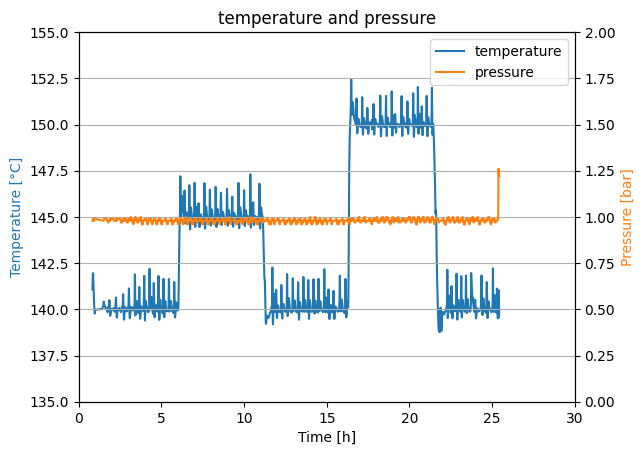

In [ ]:
# @title temperature and pressure experimental

x = Aziz_MSR_003['Time (h)']
y1 = Aziz_MSR_003['Reactor Temperature (°C)']
y2 = Aziz_MSR_003['Conversion %']
y3 = Aziz_MSR_003['Reactor Pressure (bar)']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'tab:blue', label='temperature')
ax2.plot(x, y3, 'tab:orange', label='pressure')

ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Temperature [°C]', color = 'tab:blue')
ax2.set_ylabel('Pressure [bar]', color ='tab:orange')
ax1.axis((0, 30, 135, 155))
ax2.axis((0, 30, 0, 2))
plt.title('temperature and pressure')
plt.legend(loc='best')
plt.grid()


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

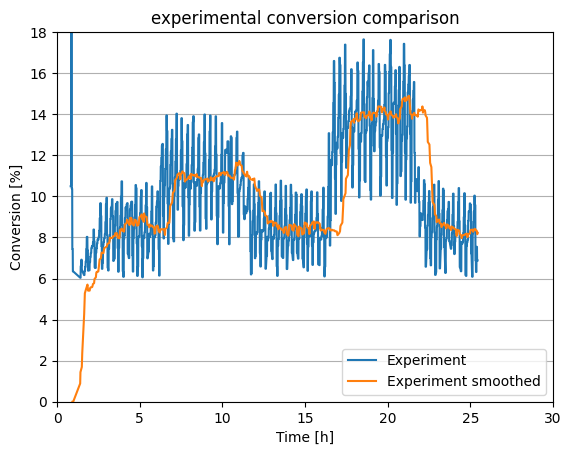

In [ ]:
# @title conversion smoothed comparison

x1 = Aziz_MSR_003['Time (h)']
y1 = Aziz_MSR_003['Conversion %']
x2 = Aziz_MSR_003_dropped['Time (h)']
y2 = Aziz_MSR_003_dropped['Conversion % mean2']

plt.figure(1)

plt.plot(x1, y1, label='Experiment')
plt.plot(x2, y2, label='Experiment smoothed')
#plt.plot(conversion_Aziz_MSR_006_model_over_time[:, 0], conversion_Aziz_MSR_006_model_over_time[:, 1], label='Model')
plt.xlabel("Time [h]")
plt.ylabel("Conversion [%]")
plt.title('experimental conversion comparison')
plt.axis((0, 30, 0, 18))
plt.legend(loc='best')

plt.grid(axis='y')

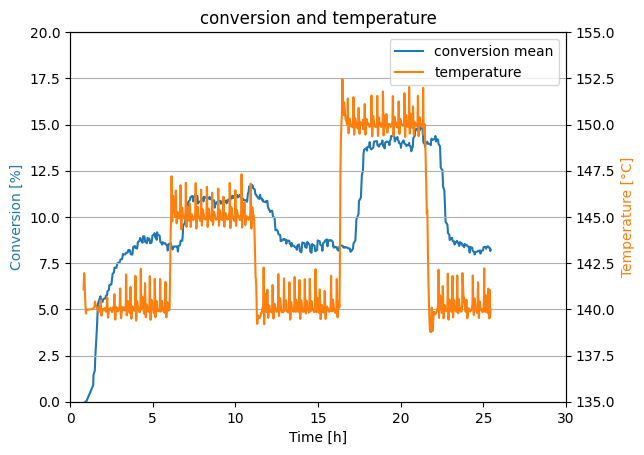

In [ ]:
# @title conversion and temperature experimental

x1 = Aziz_MSR_003['Time (h)']
x2 = Aziz_MSR_003_dropped['Time (h)']
y1 = Aziz_MSR_003_dropped['Conversion % mean2']
y2 = Aziz_MSR_003['Reactor Temperature (°C)']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x2, y1, 'tab:blue', label='conversion mean')
ax2.plot(x1, y2, 'tab:orange', label='temperature')

ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Conversion [%]', color ='tab:blue')
ax2.set_ylabel('Temperature [°C]', color ='tab:orange')
ax1.axis((0, 30, 0, 20))
ax2.axis((0, 30, 135, 155))
plt.title('conversion and temperature')
plt.legend(loc='best')
plt.grid()


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

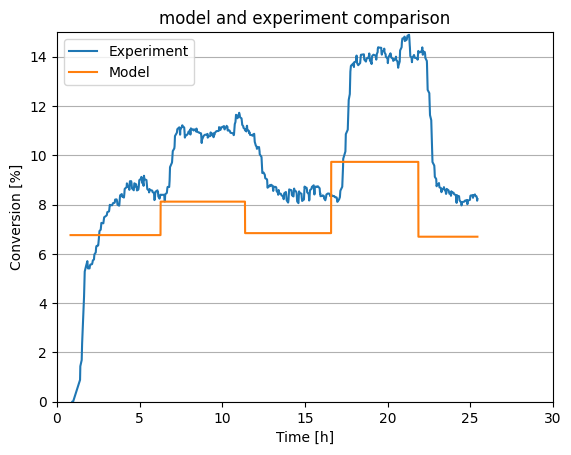

In [ ]:
# @title conversion comparison

x = Aziz_MSR_003_dropped['Time (h)']
y = Aziz_MSR_003_dropped['Conversion % mean2']

plt.figure(1)

plt.plot(x, y, label='Experiment')
plt.plot(conversion_Aziz_MSR_003_model_over_time[:, 0], conversion_Aziz_MSR_003_model_over_time[:, 1], label='Model')
plt.xlabel("Time [h]")
plt.ylabel("Conversion [%]")
plt.title('model and experiment comparison')
plt.axis((0, 30, 0, 15))
plt.legend(loc='best')

plt.grid(axis='y')

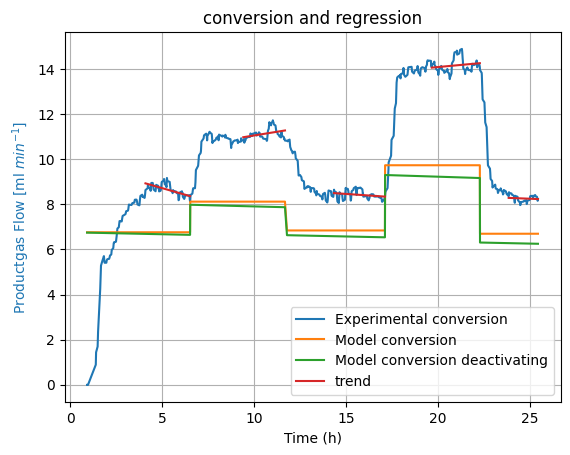

In [ ]:
# @title conversion and regression plot experimental

x003 = list(Aziz_MSR_003_dropped['Time (h)'])
y003 = list(Aziz_MSR_003_dropped['Conversion % mean2'])

x0032 = Aziz_MSR_003_deactivation_data[:, 1]
y0032 = Aziz_MSR_003_deactivation_data[:, 0]

plt.figure(1)

plt.plot(x003, y003, label='Experimental conversion')
plt.plot(x0032, y0032, label='Model conversion')
plt.plot(Xt_003[:, 1], Xt_003[:, 0], label='Model conversion deactivating')

plt.plot(Aziz_MSR_003_regression_trend[0][0], Aziz_MSR_003_regression_trend[0][1], label = 'trend', color = 'tab:red')
for i in range (len(Aziz_MSR_003_regression_trend)-1):
    plt.plot(Aziz_MSR_003_regression_trend[i+1][0], Aziz_MSR_003_regression_trend[i+1][1], color = 'tab:red')

plt.xlabel('Time (h)')
plt.ylabel('Productgas Flow [ml $min^{-1}$]', color = 'tab:blue')
#plt.axis((0, 40, 4, 14))
plt.title('conversion and regression')
plt.legend(loc='best')
plt.grid()


### MSR 005

#### Data manip

In [ ]:
# @title experimental data extraction | simple

molar_volume_ideal_gas = 24210 # [ml mol-1]
V_lN_in_Aziz_MSR_005 = 0.0023 #[lN h^-1]

filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/#2 Validation_DN - Calculation MSR - 20220504_MSR_005 - 6g 1to1.xlsx'
Aziz_MSR_005 = pd.read_excel(filepath, sheet_name ='Calculated data', usecols='D:G, I:M, O:P', header = 5)
Aziz_MSR_005 = Aziz_MSR_005.dropna(how='all')
Aziz_MSR_005 = Aziz_MSR_005.drop(0, axis=0)
#Aziz_MSR_005 = Aziz_MSR_005.drop(index=Aziz_MSR_005.index[-2:])

cat_mass_Aziz_MSR_005 = pd.read_excel(filepath, sheet_name ='Calculated data', index_col=None, usecols = "F", header = 0, nrows=0)
cat_mass_Aziz_MSR_005 = cat_mass_Aziz_MSR_005.columns.values[0]/1000

n_in_Aziz_MSR_005 = pd.read_excel(filepath, sheet_name ='results', index_col=None, usecols = "D", header = 0, nrows=8)
n_in_Aziz_MSR_005_MeOH = n_in_Aziz_MSR_005.iat[5, 0]/1000/2 #mol/h -> kmol/h
n_in_Aziz_MSR_005_H2O = n_in_Aziz_MSR_005.iat[5, 0]/1000/2

Aziz_MSR_005_dropped = Aziz_MSR_005.copy()
Aziz_MSR_005_dropped['Conversion % mean'] = Aziz_MSR_005_dropped['Conversion %'].rolling(25).mean()
Aziz_MSR_005_dropped['Conversion % smoothed'] = (Aziz_MSR_005_dropped['Conversion %'] - Aziz_MSR_005_dropped['Conversion % mean']).abs()

Aziz_MSR_005_dropped.loc[(Aziz_MSR_005_dropped['Conversion % smoothed'].diff(7) > 0.2) & (Aziz_MSR_005_dropped['Conversion % smoothed'].diff(-7) > 0.2), 'diff group'] = 1
Aziz_MSR_005_dropped.loc[(Aziz_MSR_005_dropped['Conversion % smoothed'].diff(7) < 0.2) & (Aziz_MSR_005_dropped['Conversion % smoothed'].diff(-7) < 0.2), 'diff group'] = 0
Aziz_MSR_005_dropped = Aziz_MSR_005_dropped[Aziz_MSR_005_dropped['diff group'] == 0]
Aziz_MSR_005_dropped['Conversion % mean2'] = Aziz_MSR_005_dropped['Conversion %'].rolling(25).mean()

Aziz_MSR_005_dropped['tempdiff'] = Aziz_MSR_005_dropped['Reactor Temperature (°C)'].rolling(25).mean()
Aziz_MSR_005_dropped['avgtempdiff'] = Aziz_MSR_005_dropped['tempdiff'].diff(10).abs()
Aziz_MSR_005_dropped = Aziz_MSR_005_dropped[Aziz_MSR_005_dropped['Conversion %'] > 5]
Aziz_MSR_005_dropped['groups'] = (Aziz_MSR_005_dropped['avgtempdiff'] > 2).cumsum()
Aziz_MSR_005_dropped['groups2'] = ((Aziz_MSR_005_dropped['groups'].diff(1) == 1) & (Aziz_MSR_005_dropped['groups'].diff(-1) == 0)).cumsum()

Aziz_MSR_005['tempdiff'] = Aziz_MSR_005['Reactor Temperature (°C)'].rolling(25).mean()
Aziz_MSR_005['avgtempdiff'] = Aziz_MSR_005['tempdiff'].diff(10).abs()
Aziz_MSR_005 = Aziz_MSR_005[Aziz_MSR_005['Conversion %'] > 5]
Aziz_MSR_005['groups'] = (Aziz_MSR_005['avgtempdiff'] > 2).cumsum()
Aziz_MSR_005['groups2'] = ((Aziz_MSR_005['groups'].diff(1) == 1) & (Aziz_MSR_005['groups'].diff(-1) == 0)).cumsum()

# criteria = Aziz_MSR_005.groupby('groups')['groups'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
# Aziz_MSR_005_means = Aziz_MSR_005[criteria].groupby('groups').mean()

Aziz_MSR_005_means = Aziz_MSR_005.groupby('groups2').mean()

# # @title misc calcs

Aziz_MSR_005_means_array = Aziz_MSR_005_means.to_numpy()

compEul_Aziz_MSR_005 = np.zeros([len(Aziz_MSR_005_means_array), len(IC)])

IC_Aziz_MSR_005 = np.array([0, n_in_Aziz_MSR_005_H2O, 0, 0, n_in_Aziz_MSR_005_MeOH, 0])
prodFlow_Aziz_MSR_005_model = np.zeros([len(Aziz_MSR_005_means_array)])
H2CO2_ratio_Aziz_MSR_005 = np.zeros([len(Aziz_MSR_005_means_array)])
conversion_Aziz_MSR_005_model = np.zeros([len(Aziz_MSR_005_means_array)])

for i in range (len(Aziz_MSR_005_means_array)):

  T_Aziz = Aziz_MSR_005_means_array[i, 9] + 273
  p_Aziz = Aziz_MSR_005_means_array[i, 10]

  compEul_Aziz_MSR_005 [i, :] = MainCalcMolFlow(IC_Aziz_MSR_005, T_Aziz, p_Aziz, 0, cat_mass_Aziz_MSR_005)
  prodFlow_Aziz_MSR_005_model [i] = (compEul_Aziz_MSR_005 [i, 0] + compEul_Aziz_MSR_005 [i, 2] + compEul_Aziz_MSR_005 [i, 3]) *molar_volume_ideal_gas/60*1000
  H2CO2_ratio_Aziz_MSR_005[i] = compEul_Aziz_MSR_005 [i, 0]/compEul_Aziz_MSR_005 [i, 3]
  if n_in_Aziz_MSR_005_MeOH < n_in_Aziz_MSR_005_H2O:
    conversion_Aziz_MSR_005_model [i] = (1-compEul_Aziz_MSR_005 [i, 4]/(n_in_Aziz_MSR_005_MeOH))*100
  else:
    conversion_Aziz_MSR_005_model [i] = (1-compEul_Aziz_MSR_005 [i, 1]/(n_in_Aziz_MSR_005_H2O))*100

Aziz_MSR_005_means_production_flow = Aziz_MSR_005_means['Total H2 and CO2 flowrate (ml/min)'].to_numpy()
Aziz_MSR_005_means_methanol_conversion = Aziz_MSR_005_means['Conversion %'].to_numpy()

offset_to_experiment_production_Aziz_MSR_005 = (1 - prodFlow_Aziz_MSR_005_model/Aziz_MSR_005_means_production_flow)*100
offset_to_experiment_conversion_Aziz_MSR_005 = (1 - conversion_Aziz_MSR_005_model/Aziz_MSR_005_means_methanol_conversion)*100

print('last results entry in each iteration: ', end='\n\n')
print(compEul_Aziz_MSR_005[:, 4])
# print(n_in_Aziz_MSR_005/2)
# print(H2CO2_ratio_Aziz_MSR_005)
# print(dm_cat_mass_Aziz_MSR_005)
# print(cat_mass_Aziz_MSR_005)

last results entry in each iteration: 

[3.75552398e-05 3.70025485e-05 3.63800680e-05]


In [ ]:
# @title testing
# Aziz_MSR_005
# n_in_Aziz_MSR_005
# n_in_Aziz_MSR_005_MeOH
# max_temp_diff
Aziz_MSR_005_means


,Time (s),Time (h),CO outlet concentration (vol%),CO2 outlet concentration (vol%),H2 outlet concentration (vol%),Calc. N2 concentration (vol%),Total product volumetric flowrate (ml/min),Total H2 and CO2 flowrate (ml/min),Conversion %,Reactor Temperature (°C),Reactor Pressure (bar),tempdiff,avgtempdiff,groups
groups2,,,,,,,,,,,,,,
0,19507.918455,5.418866,-0.033529,2.509575,8.291102,88.185773,34.044160,3.994857,6.596527,140.152650,0.977339,140.079228,0.108448,0.059013
1,46323.682310,12.867690,-0.030916,3.466165,10.119480,85.433882,35.138704,5.099012,8.419769,145.232329,0.976859,145.109842,0.132931,11.099278
2,57630.000000,16.008333,-0.029972,4.286794,12.169633,82.555318,36.365056,6.321188,10.437894,150.044268,0.975924,150.071361,0.148441,22.000000


In [ ]:
# @title printing results

# print(Aziz_MSR_005_means_production_flow)
# print(prodFlow_Aziz_MSR_005_model)
print(Aziz_MSR_005_means_methanol_conversion)
print(conversion_Aziz_MSR_005_model)
# print(Aziz_MSR_005_means_array)
# compEul_Aziz_MSR_005

[ 6.59652698  8.41976896 10.43789379]
[6.11190044 7.4936286  9.04982978]


In [ ]:
#@title deactivation

Aziz_MSR_005_reg = Aziz_MSR_005_dropped[(Aziz_MSR_005_dropped['Conversion % mean2'] > 4)]

reg_criteria = Aziz_MSR_005_reg.groupby('groups2')['groups2'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
Aziz_MSR_005_reg = Aziz_MSR_005_reg[reg_criteria]

Aziz_MSR_005_deactivation_data = np.zeros((len(Aziz_MSR_005_means) * 2, 4))

for i in range(len(Aziz_MSR_005_means)):
        Aziz_MSR_005_deactivation_data [i*2, :] = (conversion_Aziz_MSR_005_model [i], Aziz_MSR_005_dropped[Aziz_MSR_005_dropped['groups2'] == i]['Time (h)'].iat[0], Aziz_MSR_005_means.iat[i, 9] + 273, Aziz_MSR_005_means.iat[i, 10])
        Aziz_MSR_005_deactivation_data [i*2 + 1, :] = (conversion_Aziz_MSR_005_model [i], Aziz_MSR_005_dropped[Aziz_MSR_005_dropped['groups2'] == i]['Time (h)'].iat[-1], Aziz_MSR_005_means.iat[i, 9] + 273, Aziz_MSR_005_means.iat[i, 10])

Aziz_MSR_005_regression_fit = np.zeros((len(Aziz_MSR_005_means), 2))
Aziz_MSR_005_regression_trend = {}

regression_array_Aziz_MSR_005 = np.zeros(len(Aziz_MSR_005_means))

x1 = list(Aziz_MSR_005_reg['Time (h)'])

for i in range(len(Aziz_MSR_005_means)):
    x11 = list(Aziz_MSR_005_reg[Aziz_MSR_005_reg['groups2'] == i]['Time (h)'])
    y11 = list(Aziz_MSR_005_reg[Aziz_MSR_005_reg['groups2'] == i]['Conversion % mean2'])

    Aziz_MSR_005_regression_fit[i, :] = np.polyfit(x11, y11, deg = 1)
    Aziz_MSR_005_regression_trend [i] = [x11, np.polyval(Aziz_MSR_005_regression_fit[i, :], x11)]

    # for j in range(len(Aziz_MSR_005_reg[Aziz_MSR_005_reg['group'] == i]['Time (h)'])):
    #     Aziz_MSR_005_regression_trend[len(Aziz_MSR_005_reg[Aziz_MSR_005_reg['group'] == i - 1]['Time (h)']) + j] = Aziz_MSR_005_regression_trend_temp[j]

Xt_005 = np.zeros((len(Aziz_MSR_005_deactivation_data), 2))

Xt_005 = DeacFun(Aziz_MSR_005_deactivation_data)

for i in range(len(Aziz_MSR_005_means)):
    regression_array_Aziz_MSR_005[i] = Aziz_MSR_005_regression_fit[i, 0]/conversion_Aziz_MSR_005_model[i]/(Aziz_MSR_005_means_array[i, 9] + 273)/(Aziz_MSR_005_means_array[i, 10]**2.228)

print("regression polyfit: " + str(Aziz_MSR_005_regression_fit[:, 0]))
print("regression array: " + str(regression_array_Aziz_MSR_005))

# playing around with deactivation value extraction

#deactivation_list[5] = regression_array_Aziz_MSR_005

regression polyfit: [0.08944062 0.12854993 0.11192212]
regression array: [3.72758180e-05 4.32132027e-05 3.08653549e-05]


In [ ]:
# @title creating model plotting array

timeslots_Aziz_MSR_005 = Aziz_MSR_005.groupby('groups2')['Time (h)'].agg(['first','last']).to_numpy()

timeslots_Aziz_MSR_005
conversion_Aziz_MSR_005_model
conversion_Aziz_MSR_005_model_over_time = np.zeros([len(conversion_Aziz_MSR_005_model)*2, 2])


for j in range(len(conversion_Aziz_MSR_005_model)):
  conversion_Aziz_MSR_005_model_over_time[j*2, 1] = conversion_Aziz_MSR_005_model[j]
  conversion_Aziz_MSR_005_model_over_time[j*2+1, 1] = conversion_Aziz_MSR_005_model[j]
  conversion_Aziz_MSR_005_model_over_time [j*2, 0] = timeslots_Aziz_MSR_005[j, 0]
  conversion_Aziz_MSR_005_model_over_time [j*2+1, 0] = timeslots_Aziz_MSR_005[j, 1]

#conversion_Aziz_MSR_005_model_over_time

#### plots

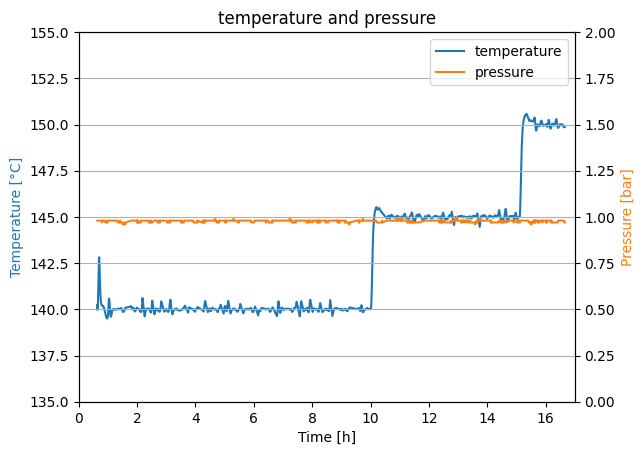

In [ ]:
# @title temperature and pressure experimental

x = Aziz_MSR_005['Time (h)']
y1 = Aziz_MSR_005['Reactor Temperature (°C)']
y2 = Aziz_MSR_005['Conversion %']
y3 = Aziz_MSR_005['Reactor Pressure (bar)']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'tab:blue', label='temperature')
ax2.plot(x, y3, 'tab:orange', label='pressure')


ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Temperature [°C]', color = 'tab:blue')
ax2.set_ylabel('Pressure [bar]', color ='tab:orange')
ax1.axis((0, 17, 135, 155))
ax2.axis((0, 17, 0, 2))
plt.title('temperature and pressure')
plt.legend(loc='best')
plt.grid()


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

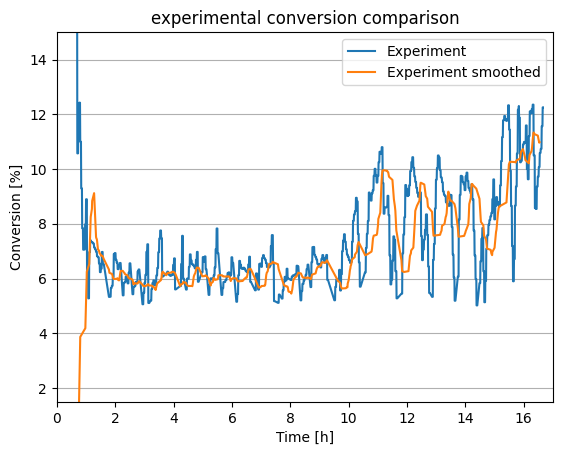

In [ ]:
# @title conversion smoothed comparison

x1 = Aziz_MSR_005['Time (h)']
y1 = Aziz_MSR_005['Conversion %']
x2 = Aziz_MSR_005_dropped['Time (h)']
y2 = Aziz_MSR_005_dropped['Conversion % mean2']

plt.figure(1)

plt.plot(x1, y1, label='Experiment')
plt.plot(x2, y2, label='Experiment smoothed')
#plt.plot(conversion_Aziz_MSR_006_model_over_time[:, 0], conversion_Aziz_MSR_006_model_over_time[:, 1], label='Model')
plt.xlabel("Time [h]")
plt.ylabel("Conversion [%]")
plt.title('experimental conversion comparison')
plt.axis((0, 17, 1.5, 15))
plt.legend(loc='best')
plt.grid(axis='y')

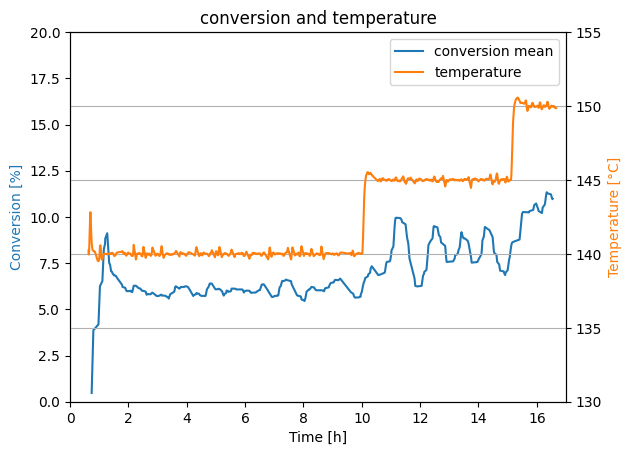

In [ ]:
# @title temperature and conversion experimental

x1 = Aziz_MSR_005['Time (h)']
x2 = Aziz_MSR_005_dropped['Time (h)']
y1 = Aziz_MSR_005_dropped['Conversion % mean2']
y2 = Aziz_MSR_005['Reactor Temperature (°C)']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x2, y1, 'tab:blue', label='conversion mean')
ax2.plot(x1, y2, 'tab:orange', label='temperature')

ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Conversion [%]', color ='tab:blue')
ax2.set_ylabel('Temperature [°C]', color ='tab:orange')
ax1.axis((0, 17, 0, 20))
ax2.axis((0, 17, 130, 155))
plt.title('conversion and temperature')
plt.legend(loc='best')
plt.grid()


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

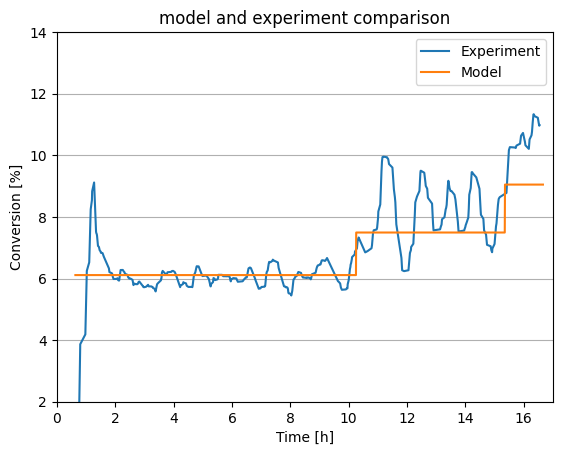

In [ ]:
# @title conversion comparison

x = Aziz_MSR_005_dropped['Time (h)']
y = Aziz_MSR_005_dropped['Conversion % mean2']

plt.figure(1)

plt.plot(x, y, label='Experiment')
plt.plot(conversion_Aziz_MSR_005_model_over_time[:, 0], conversion_Aziz_MSR_005_model_over_time[:, 1], label='Model')
plt.xlabel("Time [h]")
plt.ylabel("Conversion [%]")
plt.title('model and experiment comparison')
plt.axis((0, 17, 2, 14))
plt.legend(loc='best')
plt.grid(axis='y')

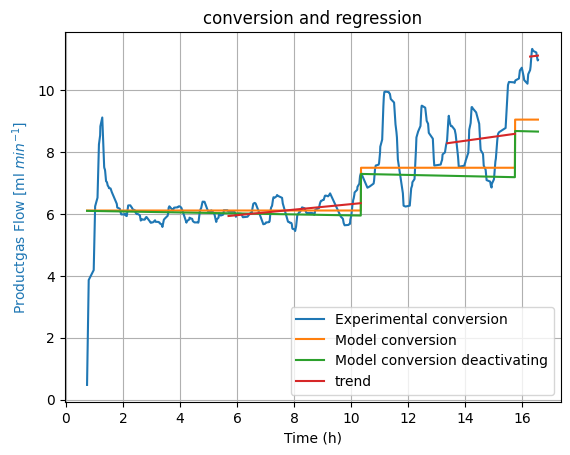

In [ ]:
# @title conversion and regression plot experimental

x005 = list(Aziz_MSR_005_dropped['Time (h)'])
y005 = list(Aziz_MSR_005_dropped['Conversion % mean2'])

x0052 = Aziz_MSR_005_deactivation_data[:, 1]
y0052 = Aziz_MSR_005_deactivation_data[:, 0]

plt.figure(1)

plt.plot(x005, y005, label='Experimental conversion')
plt.plot(x0052, y0052, label='Model conversion')
plt.plot(Xt_005[:, 1], Xt_005[:, 0], label='Model conversion deactivating')

plt.plot(Aziz_MSR_005_regression_trend[0][0], Aziz_MSR_005_regression_trend[0][1], label = 'trend', color = 'tab:red')
for i in range (len(Aziz_MSR_005_regression_trend)-1):
    plt.plot(Aziz_MSR_005_regression_trend[i+1][0], Aziz_MSR_005_regression_trend[i+1][1], color = 'tab:red')

plt.xlabel('Time (h)')
plt.ylabel('Productgas Flow [ml $min^{-1}$]', color = 'tab:blue')
#plt.axis((0, 40, 4, 14))
plt.title('conversion and regression')
plt.legend(loc='best')
plt.grid()


### MSR 006

#### Data manip

In [ ]:
# @title experimental data extraction | simple

molar_volume_ideal_gas = 24210 # [ml mol-1]
V_lN_in_Aziz_MSR_006 = 0.0023 #[lN h^-1]

filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/#2 Validation_DN - Calculation MSR - 20220505_MSR_006 - 7g 1to1.xlsx'
Aziz_MSR_006 = pd.read_excel(filepath, sheet_name ='Calculated data', usecols='D:G, I:M, O:P', header = 5)
Aziz_MSR_006 = Aziz_MSR_006.dropna(how='all')
Aziz_MSR_006 = Aziz_MSR_006.drop(0, axis=0)
#Aziz_MSR_006 = Aziz_MSR_006.drop(index=Aziz_MSR_006.index[-2:])

cat_mass_Aziz_MSR_006 = pd.read_excel(filepath, sheet_name ='Calculated data', index_col=None, usecols = "F", header = 0, nrows=0)
cat_mass_Aziz_MSR_006 = cat_mass_Aziz_MSR_006.columns.values[0]/1000

n_in_Aziz_MSR_006 = pd.read_excel(filepath, sheet_name ='results', index_col=None, usecols = "E", header = 0, nrows=8)
n_in_Aziz_MSR_006_MeOH = n_in_Aziz_MSR_006.iat[5, 0]/2/1000 #mol/h -> kmol/h
n_in_Aziz_MSR_006_H2O = n_in_Aziz_MSR_006.iat[5, 0]/2/1000

Aziz_MSR_006_dropped = Aziz_MSR_006.copy()
Aziz_MSR_006_dropped['Conversion % mean'] = Aziz_MSR_006_dropped['Conversion %'].rolling(25).mean()
Aziz_MSR_006_dropped['Conversion % smoothed'] = (Aziz_MSR_006_dropped['Conversion %'] - Aziz_MSR_006_dropped['Conversion % mean']).abs()

Aziz_MSR_006_dropped.loc[(Aziz_MSR_006_dropped['Conversion % smoothed'].diff(7) > 0.2) & (Aziz_MSR_006_dropped['Conversion % smoothed'].diff(-7) > 0.2), 'diff group'] = 1
Aziz_MSR_006_dropped.loc[(Aziz_MSR_006_dropped['Conversion % smoothed'].diff(7) < 0.2) & (Aziz_MSR_006_dropped['Conversion % smoothed'].diff(-7) < 0.2), 'diff group'] = 0
Aziz_MSR_006_dropped = Aziz_MSR_006_dropped[Aziz_MSR_006_dropped['diff group'] == 0]
Aziz_MSR_006_dropped['Conversion % mean2'] = Aziz_MSR_006_dropped['Conversion %'].rolling(25).mean().shift(10)

Aziz_MSR_006_dropped['tempdiff'] = Aziz_MSR_006_dropped['Reactor Temperature (°C)'].rolling(25).mean()
Aziz_MSR_006_dropped['avgtempdiff'] = Aziz_MSR_006_dropped['tempdiff'].diff(10).abs()
Aziz_MSR_006_dropped = Aziz_MSR_006_dropped[Aziz_MSR_006_dropped['Conversion %'] > 5]
Aziz_MSR_006_dropped['groups'] = (Aziz_MSR_006_dropped['avgtempdiff'] > 2).cumsum()
Aziz_MSR_006_dropped['groups2'] = ((Aziz_MSR_006_dropped['groups'].diff(1) == 1) & (Aziz_MSR_006_dropped['groups'].diff(-1) == 0)).cumsum()

Aziz_MSR_006['tempdiff'] = Aziz_MSR_006['Reactor Temperature (°C)'].rolling(25).mean()
Aziz_MSR_006['avgtempdiff'] = Aziz_MSR_006['tempdiff'].diff(10).abs()
Aziz_MSR_006 = Aziz_MSR_006[Aziz_MSR_006['Conversion %'] > 5]
Aziz_MSR_006['groups'] = (Aziz_MSR_006['avgtempdiff'] > 2).cumsum()
Aziz_MSR_006['groups2'] = ((Aziz_MSR_006['groups'].diff(1) == 1) & (Aziz_MSR_006['groups'].diff(-1) == 0)).cumsum()

# criteria = Aziz_MSR_006.groupby('groups')['groups'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
# Aziz_MSR_006_means = Aziz_MSR_006[criteria].groupby('groups').mean()

Aziz_MSR_006_means = Aziz_MSR_006.groupby('groups2').mean()

# # @title misc calcs

Aziz_MSR_006_means_array = Aziz_MSR_006_means.to_numpy()

compEul_Aziz_MSR_006 = np.zeros([len(Aziz_MSR_006_means_array), len(IC)])

IC_Aziz_MSR_006 = np.array([0, n_in_Aziz_MSR_006_H2O, 0, 0, n_in_Aziz_MSR_006_MeOH, 0])
prodFlow_Aziz_MSR_006_model = np.zeros([len(Aziz_MSR_006_means_array)])
H2CO2_ratio_Aziz_MSR_006 = np.zeros([len(Aziz_MSR_006_means_array)])
conversion_Aziz_MSR_006_model = np.zeros([len(Aziz_MSR_006_means_array)])

for i in range (len(Aziz_MSR_006_means_array)):

  T_Aziz = Aziz_MSR_006_means_array[i, 9] + 273
  p_Aziz = Aziz_MSR_006_means_array[i, 10]

  compEul_Aziz_MSR_006 [i, :] = MainCalcMolFlow(IC_Aziz_MSR_006, T_Aziz, p_Aziz, 0, cat_mass_Aziz_MSR_006)
  prodFlow_Aziz_MSR_006_model [i] = (compEul_Aziz_MSR_006 [i, 0] + compEul_Aziz_MSR_006 [i, 2] + compEul_Aziz_MSR_006 [i, 3]) *molar_volume_ideal_gas/60*1000
  H2CO2_ratio_Aziz_MSR_006[i] = compEul_Aziz_MSR_006 [i, 0]/compEul_Aziz_MSR_006 [i, 3]

  if n_in_Aziz_MSR_006_MeOH < n_in_Aziz_MSR_006_H2O:
    conversion_Aziz_MSR_006_model [i] = (1-compEul_Aziz_MSR_006 [i, 4]/(n_in_Aziz_MSR_006_MeOH))*100
  else:
    conversion_Aziz_MSR_006_model [i] = (1-compEul_Aziz_MSR_006 [i, 1]/(n_in_Aziz_MSR_006_H2O))*100

Aziz_MSR_006_means_production_flow = Aziz_MSR_006_means['Total H2 and CO2 flowrate (ml/min)'].to_numpy()
Aziz_MSR_006_means_methanol_conversion = Aziz_MSR_006_means['Conversion %'].to_numpy()

offset_to_experiment_production_Aziz_MSR_006 = (1 - prodFlow_Aziz_MSR_006_model/Aziz_MSR_006_means_production_flow)*100
offset_to_experiment_conversion_Aziz_MSR_006 = (1 - conversion_Aziz_MSR_006_model/Aziz_MSR_006_means_methanol_conversion)*100

print('last results entry in each iteration: ', end='\n\n')
print(compEul_Aziz_MSR_006[:, 4])
# print(n_in_Aziz_MSR_006/2)
# print(H2CO2_ratio_Aziz_MSR_006)
# print(dm_cat_mass_Aziz_MSR_006)
# print(cat_mass_Aziz_MSR_006)

last results entry in each iteration: 

[3.71683701e-05 3.65405815e-05 3.59073919e-05 3.72050623e-05]


In [ ]:
# @title testing
# Aziz_MSR_006
# n_in_Aziz_MSR_006
# n_in_Aziz_MSR_006_MeOH
# max_temp_diff
Aziz_MSR_006_means


,Time (s),Time (h),CO outlet concentration (vol%),CO2 outlet concentration (vol%),H2 outlet concentration (vol%),Calc. N2 concentration (vol%),Total product volumetric flowrate (ml/min),Total H2 and CO2 flowrate (ml/min),Conversion %,Reactor Temperature (°C),Reactor Pressure (bar),tempdiff,avgtempdiff,groups
groups2,,,,,,,,,,,,,,
0,12428.277592,3.452299,-0.058836,2.672951,8.838657,87.078255,34.516695,4.491657,7.416870,140.215268,0.976555,140.119811,0.136582,0.091973
1,31656.352941,8.793431,-0.043557,3.728803,10.421097,84.576163,35.489286,5.510621,9.099440,145.206471,0.976924,145.108223,0.131743,11.110924
2,50400.000000,14.000000,-0.046499,4.572666,12.856235,81.325301,36.921273,6.953832,11.482550,149.487071,0.977496,149.694852,0.204000,23.639370
3,62480.851064,17.355792,-0.062798,2.941007,8.305859,87.498906,34.293102,4.320458,7.134178,139.894184,0.972057,139.820786,0.184953,52.000000


In [ ]:
# @title printing results

# print(Aziz_MSR_006_means_production_flow)
# print(prodFlow_Aziz_MSR_006_model)
print(Aziz_MSR_006_means_methanol_conversion)
print(conversion_Aziz_MSR_006_model)
# print(Aziz_MSR_006_means_array)
# compEul_Aziz_MSR_006

[ 7.4168704   9.0994396  11.48254972  7.13417776]
[ 7.07907477  8.648546   10.23151993  6.9873442 ]


In [ ]:
#@title deactivation

Aziz_MSR_006_reg = Aziz_MSR_006_dropped[(Aziz_MSR_006_dropped['Conversion % mean2'] > 4)]

reg_criteria = Aziz_MSR_006_reg.groupby('groups2')['groups2'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
Aziz_MSR_006_reg = Aziz_MSR_006_reg[reg_criteria]

Aziz_MSR_006_deactivation_data = np.zeros((len(Aziz_MSR_006_means) * 2, 4))

for i in range(len(Aziz_MSR_006_means)):
        Aziz_MSR_006_deactivation_data [i*2, :] = (conversion_Aziz_MSR_006_model [i], Aziz_MSR_006_dropped[Aziz_MSR_006_dropped['groups2'] == i]['Time (h)'].iat[0], Aziz_MSR_006_means.iat[i, 9] + 273, Aziz_MSR_006_means.iat[i, 10])
        Aziz_MSR_006_deactivation_data [i*2 + 1, :] = (conversion_Aziz_MSR_006_model [i], Aziz_MSR_006_dropped[Aziz_MSR_006_dropped['groups2'] == i]['Time (h)'].iat[-1], Aziz_MSR_006_means.iat[i, 9] + 273, Aziz_MSR_006_means.iat[i, 10])

Aziz_MSR_006_regression_fit = np.zeros((len(Aziz_MSR_006_means), 2))
Aziz_MSR_006_regression_trend = {}

regression_array_Aziz_MSR_006 = np.zeros(len(Aziz_MSR_006_means))

x1 = list(Aziz_MSR_006_reg['Time (h)'])

for i in range(len(Aziz_MSR_006_means)):
    x11 = list(Aziz_MSR_006_reg[Aziz_MSR_006_reg['groups2'] == i]['Time (h)'])
    y11 = list(Aziz_MSR_006_reg[Aziz_MSR_006_reg['groups2'] == i]['Conversion % mean2'])

    Aziz_MSR_006_regression_fit[i, :] = np.polyfit(x11, y11, deg = 1)
    Aziz_MSR_006_regression_trend [i] = [x11, np.polyval(Aziz_MSR_006_regression_fit[i, :], x11)]

    # for j in range(len(Aziz_MSR_006_reg[Aziz_MSR_006_reg['group'] == i]['Time (h)'])):
    #     Aziz_MSR_006_regression_trend[len(Aziz_MSR_006_reg[Aziz_MSR_006_reg['group'] == i - 1]['Time (h)']) + j] = Aziz_MSR_006_regression_trend_temp[j]

Xt_006 = np.zeros((len(Aziz_MSR_006_deactivation_data), 2))

Xt_006 = DeacFun(Aziz_MSR_006_deactivation_data)

for i in range(len(Aziz_MSR_006_means)):
    regression_array_Aziz_MSR_006[i] = Aziz_MSR_006_regression_fit[i, 0]/conversion_Aziz_MSR_006_model[i]/(Aziz_MSR_006_means_array[i, 9] + 273)/(Aziz_MSR_006_means_array[i, 10]**2.228)

print("regression polyfit: " + str(Aziz_MSR_006_regression_fit[:, 0]))
print("regression array: " + str(regression_array_Aziz_MSR_006))

# playing around with deactivation value extraction

#deactivation_list[6] = regression_array_Aziz_MSR_006

regression polyfit: [ 0.06308507  0.00519809 -0.26671078  4.50878794]
regression array: [ 2.27367955e-05  1.51390884e-06 -6.49098691e-05  1.66468470e-03]


In [ ]:
# @title creating model plotting array

timeslots_Aziz_MSR_006 = Aziz_MSR_006.groupby('groups2')['Time (h)'].agg(['first','last']).to_numpy()

timeslots_Aziz_MSR_006
conversion_Aziz_MSR_006_model
conversion_Aziz_MSR_006_model_over_time = np.zeros([len(conversion_Aziz_MSR_006_model)*2, 2])


for j in range(len(conversion_Aziz_MSR_006_model)):
  conversion_Aziz_MSR_006_model_over_time[j*2, 1] = conversion_Aziz_MSR_006_model[j]
  conversion_Aziz_MSR_006_model_over_time[j*2+1, 1] = conversion_Aziz_MSR_006_model[j]
  conversion_Aziz_MSR_006_model_over_time [j*2, 0] = timeslots_Aziz_MSR_006[j, 0]
  conversion_Aziz_MSR_006_model_over_time [j*2+1, 0] = timeslots_Aziz_MSR_006[j, 1]

#conversion_Aziz_MSR_006_model_over_time

#### plots

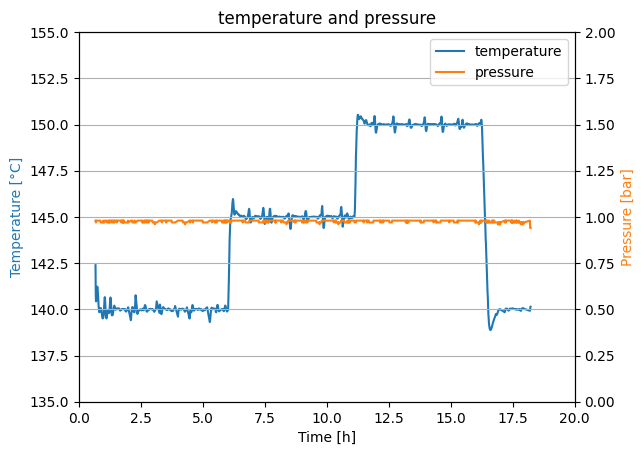

In [ ]:
# @title temperature and pressure experimental

x = Aziz_MSR_006['Time (h)']
y1 = Aziz_MSR_006['Reactor Temperature (°C)']
y2 = Aziz_MSR_006['Conversion %']
y3 = Aziz_MSR_006['Reactor Pressure (bar)']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'tab:blue', label='temperature')
ax2.plot(x, y3, 'tab:orange', label='pressure')
#ax2.plot(x, y2, 'tab:orange', label='conversion')


ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Temperature [°C]', color = 'tab:blue')
#ax2.set_ylabel('Conversion [%]', color ='tab:orange')
ax2.set_ylabel('Pressure [bar]', color ='tab:orange')
ax1.axis((0, 20, 135, 155))
#ax2.axis((0, 22, 0, 20))
ax2.axis((0, 20, 0, 2))
#plt.title('temperature and conversion')
plt.title('temperature and pressure')
plt.legend(loc='best')
plt.grid()


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

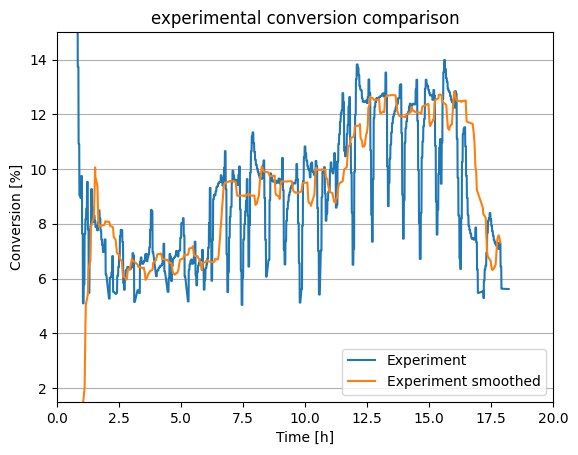

In [ ]:
# @title conversion smoothed comparison

x1 = Aziz_MSR_006['Time (h)']
y1 = Aziz_MSR_006['Conversion %']
x2 = Aziz_MSR_006_dropped['Time (h)']
y2 = Aziz_MSR_006_dropped['Conversion % mean2']

plt.figure(1)

plt.plot(x1, y1, label='Experiment')
plt.plot(x2, y2, label='Experiment smoothed')
plt.xlabel("Time [h]")
plt.ylabel("Conversion [%]")
plt.title('experimental conversion comparison')
plt.axis((0, 20, 1.5, 15))
plt.legend(loc='best')

plt.grid(axis='y')

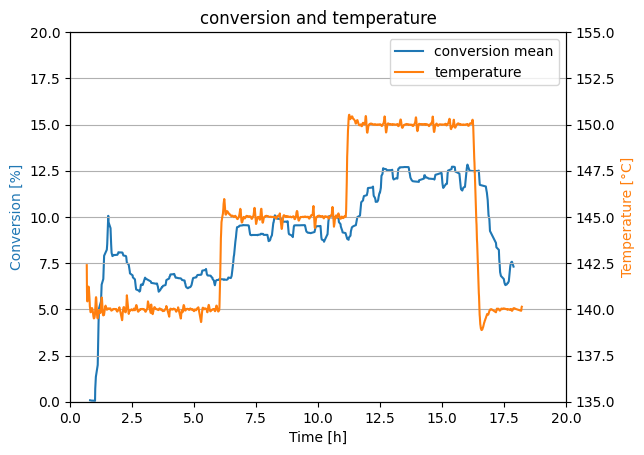

In [ ]:
# @title temperature and conversion experimental

x1 = Aziz_MSR_006['Time (h)']
x2 = Aziz_MSR_006_dropped['Time (h)']
y1 = Aziz_MSR_006_dropped['Conversion % mean2']
y2 = Aziz_MSR_006['Reactor Temperature (°C)']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x2, y1, 'tab:blue', label='conversion mean')
ax2.plot(x1, y2, 'tab:orange', label='temperature')

ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Conversion [%]', color ='tab:blue')
ax2.set_ylabel('Temperature [°C]', color ='tab:orange')
ax1.axis((0, 20, 0, 20))
ax2.axis((0, 20, 135, 155))
plt.title('conversion and temperature')
plt.legend(loc='best')
plt.grid()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

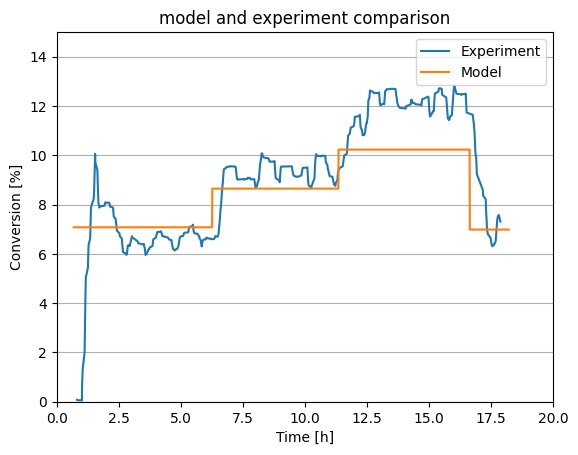

In [ ]:
# @title conversion comparison

x = Aziz_MSR_006_dropped['Time (h)']
y = Aziz_MSR_006_dropped['Conversion % mean2']

plt.figure(1)

plt.plot(x, y, label='Experiment')
plt.plot(conversion_Aziz_MSR_006_model_over_time[:, 0], conversion_Aziz_MSR_006_model_over_time[:, 1], label='Model')
plt.xlabel("Time [h]")
plt.ylabel("Conversion [%]")
plt.title('model and experiment comparison')
plt.axis((0, 20, 0, 15))
plt.legend(loc='best')

plt.grid(axis='y')

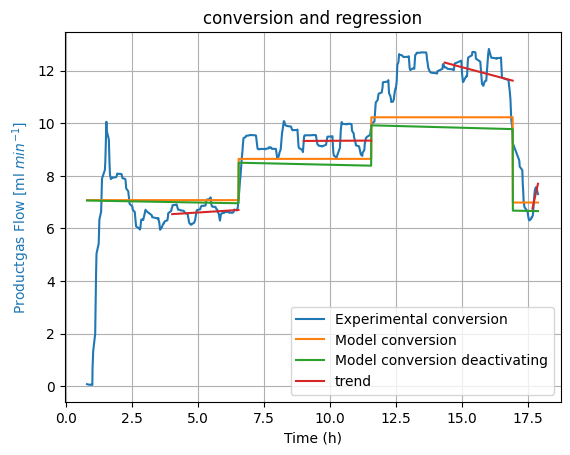

In [ ]:
# @title conversion and regression plot experimental

x006 = list(Aziz_MSR_006_dropped['Time (h)'])
y006 = list(Aziz_MSR_006_dropped['Conversion % mean2'])

x0062 = Aziz_MSR_006_deactivation_data[:, 1]
y0062 = Aziz_MSR_006_deactivation_data[:, 0]

plt.figure(1)

plt.plot(x006, y006, label='Experimental conversion')
plt.plot(x0062, y0062, label='Model conversion')
plt.plot(Xt_006[:, 1], Xt_006[:, 0], label='Model conversion deactivating')

plt.plot(Aziz_MSR_006_regression_trend[0][0], Aziz_MSR_006_regression_trend[0][1], label = 'trend', color = 'tab:red')
for i in range (len(Aziz_MSR_006_regression_trend)-1):
    plt.plot(Aziz_MSR_006_regression_trend[i+1][0], Aziz_MSR_006_regression_trend[i+1][1], color = 'tab:red')

plt.xlabel('Time (h)')
plt.ylabel('Productgas Flow [ml $min^{-1}$]', color = 'tab:blue')
#plt.axis((0, 40, 4, 14))
plt.title('conversion and regression')
plt.legend(loc='best')
plt.grid()


### MSR 008

#### Data manip

In [ ]:
#@title experimental data extraction | simple

molar_volume_ideal_gas = 24210 # [ml mol-1]
V_lN_in_Aziz_MSR_008 = 0.0023 #[lN h^-1]

filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/#2 Validation_DN - Calculation MSR - 20220510_MSR_008.xlsx'
Aziz_MSR_008 = pd.read_excel(filepath, sheet_name ='Calculated data', usecols='D:G, I:M, O:P', header = 5)
Aziz_MSR_008 = Aziz_MSR_008.dropna(how='all')
Aziz_MSR_008 = Aziz_MSR_008.drop(0, axis=0)
#Aziz_MSR_008 = Aziz_MSR_008.drop(index=Aziz_MSR_008.index[-2:])

cat_mass_Aziz_MSR_008 = pd.read_excel(filepath, sheet_name ='Calculated data', index_col=None, usecols = "F", header = 0, nrows=0)
cat_mass_Aziz_MSR_008 = cat_mass_Aziz_MSR_008.columns.values[0]/1000

n_in_Aziz_MSR_008 = pd.read_excel(filepath, sheet_name ='results', index_col=None, usecols = "E", header = 0, nrows=8)
n_in_Aziz_MSR_008_MeOH = n_in_Aziz_MSR_008.iat[5, 0]/1000/2 #mol/h -> kmol/h
n_in_Aziz_MSR_008_H2O = n_in_Aziz_MSR_008.iat[5, 0]/1000/2

Aziz_MSR_008_dropped = Aziz_MSR_008.copy()
Aziz_MSR_008_dropped['Conversion % mean'] = Aziz_MSR_008_dropped['Conversion %'].rolling(25).mean()
Aziz_MSR_008_dropped['Conversion % smoothed'] = (Aziz_MSR_008_dropped['Conversion %'] - Aziz_MSR_008_dropped['Conversion % mean']).abs()

Aziz_MSR_008_dropped.loc[(Aziz_MSR_008_dropped['Conversion % smoothed'].diff(7) > 0.2) & (Aziz_MSR_008_dropped['Conversion % smoothed'].diff(-7) > 0.2), 'diff group'] = 1
Aziz_MSR_008_dropped.loc[(Aziz_MSR_008_dropped['Conversion % smoothed'].diff(7) < 0.2) & (Aziz_MSR_008_dropped['Conversion % smoothed'].diff(-7) < 0.2), 'diff group'] = 0
Aziz_MSR_008_dropped = Aziz_MSR_008_dropped[Aziz_MSR_008_dropped['diff group'] == 0]
Aziz_MSR_008_dropped['Conversion % mean2'] = Aziz_MSR_008_dropped['Conversion %'].rolling(25).mean().shift(0)

Aziz_MSR_008_dropped['tempdiff'] = Aziz_MSR_008_dropped['Reactor Temperature (°C)'].rolling(25).mean()
Aziz_MSR_008_dropped['avgtempdiff'] = Aziz_MSR_008_dropped['tempdiff'].diff(10).abs()
Aziz_MSR_008_dropped = Aziz_MSR_008_dropped[Aziz_MSR_008_dropped['Conversion %'] > 3]
Aziz_MSR_008_dropped['groups'] = (Aziz_MSR_008_dropped['avgtempdiff'] > 1.8).cumsum()
Aziz_MSR_008_dropped['groups2'] = ((Aziz_MSR_008_dropped['groups'].diff(1) == 1) & (Aziz_MSR_008_dropped['groups'].diff(-1) == 0)).cumsum()

Aziz_MSR_008['tempdiff'] = Aziz_MSR_008['Reactor Temperature (°C)'].rolling(25).mean()
Aziz_MSR_008['avgtempdiff'] = Aziz_MSR_008['tempdiff'].diff(10).abs()
Aziz_MSR_008 = Aziz_MSR_008[Aziz_MSR_008['Conversion %'] > 3]
Aziz_MSR_008['groups'] = (Aziz_MSR_008['avgtempdiff'] > 1.8).cumsum()
Aziz_MSR_008['groups2'] = ((Aziz_MSR_008['groups'].diff(1) == 1) & (Aziz_MSR_008['groups'].diff(-1) == 0)).cumsum()

# criteria = Aziz_MSR_008.groupby('groups')['groups'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
# Aziz_MSR_008_means = Aziz_MSR_008[criteria].groupby('groups').mean()

Aziz_MSR_008_means = Aziz_MSR_008.groupby('groups2').mean()

# # @title misc calcs

Aziz_MSR_008_means_array = Aziz_MSR_008_means.to_numpy()

compEul_Aziz_MSR_008 = np.zeros([len(Aziz_MSR_008_means_array), len(IC)])

IC_Aziz_MSR_008 = np.array([0, n_in_Aziz_MSR_008_H2O, 0, 0, n_in_Aziz_MSR_008_MeOH, 0])
prodFlow_Aziz_MSR_008_model = np.zeros([len(Aziz_MSR_008_means_array)])
H2CO2_ratio_Aziz_MSR_008 = np.zeros([len(Aziz_MSR_008_means_array)])
conversion_Aziz_MSR_008_model = np.zeros([len(Aziz_MSR_008_means_array)])

for i in range (len(Aziz_MSR_008_means_array)):

  T_Aziz = Aziz_MSR_008_means_array[i, 9] + 273
  p_Aziz = Aziz_MSR_008_means_array[i, 10]

  compEul_Aziz_MSR_008 [i, :] = MainCalcMolFlow(IC_Aziz_MSR_008, T_Aziz, p_Aziz, 0, cat_mass_Aziz_MSR_008)
  prodFlow_Aziz_MSR_008_model [i] = (compEul_Aziz_MSR_008 [i, 0] + compEul_Aziz_MSR_008 [i, 2] + compEul_Aziz_MSR_008 [i, 3]) *molar_volume_ideal_gas/60*1000
  H2CO2_ratio_Aziz_MSR_008[i] = compEul_Aziz_MSR_008 [i, 0]/compEul_Aziz_MSR_008 [i, 3]
  if n_in_Aziz_MSR_008_MeOH < n_in_Aziz_MSR_008_H2O:
    conversion_Aziz_MSR_008_model [i] = (1-compEul_Aziz_MSR_008 [i, 4]/(n_in_Aziz_MSR_008_MeOH))*100
  else:
    conversion_Aziz_MSR_008_model [i] = (1-compEul_Aziz_MSR_008 [i, 1]/(n_in_Aziz_MSR_008_H2O))*100

Aziz_MSR_008_means_production_flow = Aziz_MSR_008_means['Total H2 and CO2 flowrate (ml/min)'].to_numpy()
Aziz_MSR_008_means_methanol_conversion = Aziz_MSR_008_means['Conversion %'].to_numpy()

offset_to_experiment_production_Aziz_MSR_008 = (1 - prodFlow_Aziz_MSR_008_model/Aziz_MSR_008_means_production_flow)*100
offset_to_experiment_conversion_Aziz_MSR_008 = (1 - conversion_Aziz_MSR_008_model/Aziz_MSR_008_means_methanol_conversion)*100

print('last results entry in each iteration: ', end='\n\n')
print(compEul_Aziz_MSR_008[:, 4])
# print(n_in_Aziz_MSR_008/2)
# print(H2CO2_ratio_Aziz_MSR_008)
# print(dm_cat_mass_Aziz_MSR_008)
# print(cat_mass_Aziz_MSR_008)

last results entry in each iteration: 

[3.79633913e-05 3.75218740e-05 3.70607466e-05 3.79954411e-05]


In [ ]:
# @title testing
# Aziz_MSR_008
# n_in_Aziz_MSR_008
# n_in_Aziz_MSR_008_MeOH
# max_temp_diff
Aziz_MSR_008_means

,Time (s),Time (h),CO outlet concentration (vol%),CO2 outlet concentration (vol%),H2 outlet concentration (vol%),Calc. N2 concentration (vol%),Total product volumetric flowrate (ml/min),Total H2 and CO2 flowrate (ml/min),Conversion %,Reactor Temperature (°C),Reactor Pressure (bar),tempdiff,avgtempdiff,groups
groups2,,,,,,,,,,,,,,
0,13183.561644,3.6621,-0.069467,2.022933,6.722291,89.755426,33.436211,3.051034,5.038035,140.292779,0.976928,140.192866,0.158369,0.041096
1,30150.000000,8.3750,-0.042751,3.031460,8.568478,87.112840,34.441440,4.117588,6.799188,145.184136,0.975622,145.085369,0.113972,7.033926
2,49050.000000,13.6250,-0.035942,3.785178,10.747086,84.191678,35.637121,5.306016,8.761585,149.530421,0.976271,149.711224,0.187690,14.633385
3,62055.000000,17.2375,-0.054212,2.392647,6.342773,89.885265,33.379393,3.034902,5.011397,139.902212,0.972876,139.898752,0.120604,43.000000


In [ ]:
# @title printing results

# print(Aziz_MSR_008_means_production_flow)
# print(prodFlow_Aziz_MSR_008_model)
print(Aziz_MSR_008_means_methanol_conversion)
print(conversion_Aziz_MSR_008_model)
# print(Aziz_MSR_008_means_array)
# compEul_Aziz_MSR_008

[5.03803538 6.79918819 8.76158479 5.01139658]
[5.09152162 6.1953149  7.34813344 5.01139724]


In [ ]:
#@title deactivation

Aziz_MSR_008_reg = Aziz_MSR_008_dropped[(Aziz_MSR_008_dropped['Conversion % mean2'] > 4)]

reg_criteria = Aziz_MSR_008_reg.groupby('groups2')['groups2'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
Aziz_MSR_008_reg = Aziz_MSR_008_reg[reg_criteria]

Aziz_MSR_008_deactivation_data = np.zeros((len(Aziz_MSR_008_means) * 2, 4))

for i in range(len(Aziz_MSR_008_means)):
        Aziz_MSR_008_deactivation_data [i*2, :] = (conversion_Aziz_MSR_008_model [i], Aziz_MSR_008_dropped[Aziz_MSR_008_dropped['groups2'] == i]['Time (h)'].iat[0], Aziz_MSR_008_means.iat[i, 9] + 273, Aziz_MSR_008_means.iat[i, 10])
        Aziz_MSR_008_deactivation_data [i*2 + 1, :] = (conversion_Aziz_MSR_008_model [i], Aziz_MSR_008_dropped[Aziz_MSR_008_dropped['groups2'] == i]['Time (h)'].iat[-1], Aziz_MSR_008_means.iat[i, 9] + 273, Aziz_MSR_008_means.iat[i, 10])

Aziz_MSR_008_regression_fit = np.zeros((len(Aziz_MSR_008_means), 2))
Aziz_MSR_008_regression_trend = {}

regression_array_Aziz_MSR_008 = np.zeros(len(Aziz_MSR_008_means))

x1 = list(Aziz_MSR_008_reg['Time (h)'])

for i in range(len(Aziz_MSR_008_means)):
    x11 = list(Aziz_MSR_008_reg[Aziz_MSR_008_reg['groups2'] == i]['Time (h)'])
    y11 = list(Aziz_MSR_008_reg[Aziz_MSR_008_reg['groups2'] == i]['Conversion % mean2'])

    Aziz_MSR_008_regression_fit[i, :] = np.polyfit(x11, y11, deg = 1)
    Aziz_MSR_008_regression_trend [i] = [x11, np.polyval(Aziz_MSR_008_regression_fit[i, :], x11)]

    # for j in range(len(Aziz_MSR_008_reg[Aziz_MSR_008_reg['group'] == i]['Time (h)'])):
    #     Aziz_MSR_008_regression_trend[len(Aziz_MSR_008_reg[Aziz_MSR_008_reg['group'] == i - 1]['Time (h)']) + j] = Aziz_MSR_008_regression_trend_temp[j]

Xt_008 = np.zeros((len(Aziz_MSR_008_deactivation_data), 2))

Xt_008 = DeacFun(Aziz_MSR_008_deactivation_data)

for i in range(len(Aziz_MSR_008_means)):
    regression_array_Aziz_MSR_008[i] = Aziz_MSR_008_regression_fit[i, 0]/conversion_Aziz_MSR_008_model[i]/(Aziz_MSR_008_means_array[i, 9] + 273)/(Aziz_MSR_008_means_array[i, 10]**2.228)

print("regression polyfit: " + str(Aziz_MSR_008_regression_fit[:, 0]))
print("regression array: " + str(regression_array_Aziz_MSR_008))

# playing around with deactivation value extraction

#deactivation_list[8] = regression_array_Aziz_MSR_008

regression polyfit: [ 0.10749842  0.05350256 -0.32206819 -0.37883335]
regression array: [ 5.38125149e-05  2.18184691e-05 -1.09433312e-04 -1.94648011e-04]


In [ ]:
# @title creating model plotting array

timeslots_Aziz_MSR_008 = Aziz_MSR_008.groupby('groups2')['Time (h)'].agg(['first','last']).to_numpy()

timeslots_Aziz_MSR_008
conversion_Aziz_MSR_008_model
conversion_Aziz_MSR_008_model_over_time = np.zeros([len(conversion_Aziz_MSR_008_model)*2, 2])


for j in range(len(conversion_Aziz_MSR_008_model)):
  conversion_Aziz_MSR_008_model_over_time[j*2, 1] = conversion_Aziz_MSR_008_model[j]
  conversion_Aziz_MSR_008_model_over_time[j*2+1, 1] = conversion_Aziz_MSR_008_model[j]
  conversion_Aziz_MSR_008_model_over_time [j*2, 0] = timeslots_Aziz_MSR_008[j, 0]
  conversion_Aziz_MSR_008_model_over_time [j*2+1, 0] = timeslots_Aziz_MSR_008[j, 1]

#conversion_Aziz_MSR_008_model_over_time

#### plots

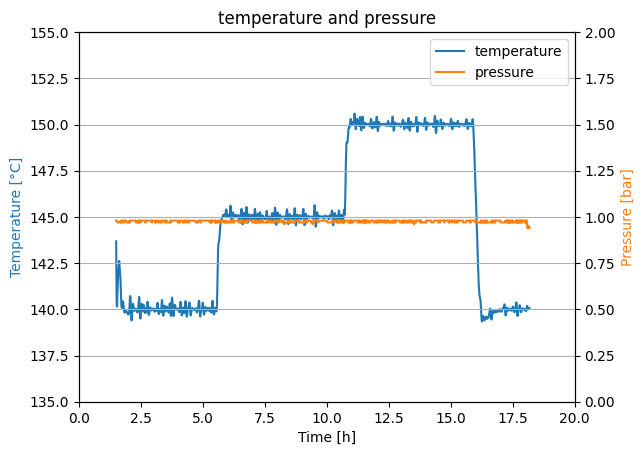

In [ ]:
# @title temperature and pressure experimental

x = Aziz_MSR_008['Time (h)']
y1 = Aziz_MSR_008['Reactor Temperature (°C)']
y2 = Aziz_MSR_008['Conversion %']
y3 = Aziz_MSR_008['Reactor Pressure (bar)']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(x, y1, 'tab:blue', label='temperature')
ax2.plot(x, y3, 'tab:orange', label='pressure')

ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Temperature [°C]', color = 'tab:blue')
ax2.set_ylabel('Pressure [bar]', color ='tab:orange')
ax1.axis((0, 20, 135, 155))
ax2.axis((0, 20, 0, 2))
plt.title('temperature and pressure')
plt.legend(loc='best')
plt.grid()


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

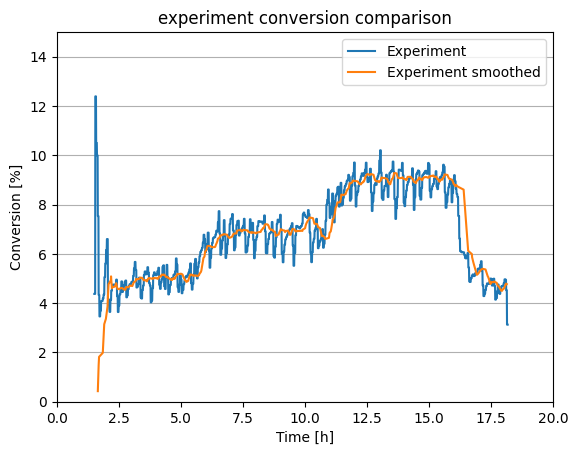

In [ ]:
# @title conversion comparison

x1 = Aziz_MSR_008['Time (h)']
y1 = Aziz_MSR_008['Conversion %']
x2 = Aziz_MSR_008_dropped['Time (h)']
y2 = Aziz_MSR_008_dropped['Conversion % mean2']
plt.figure(1)

plt.plot(x1, y1, label='Experiment')
plt.plot(x2, y2, label='Experiment smoothed')

plt.xlabel("Time [h]")
plt.ylabel("Conversion [%]")
plt.title('experiment conversion comparison')
plt.axis((0, 20, 0, 15))
plt.legend(loc='best')

plt.grid(axis='y')

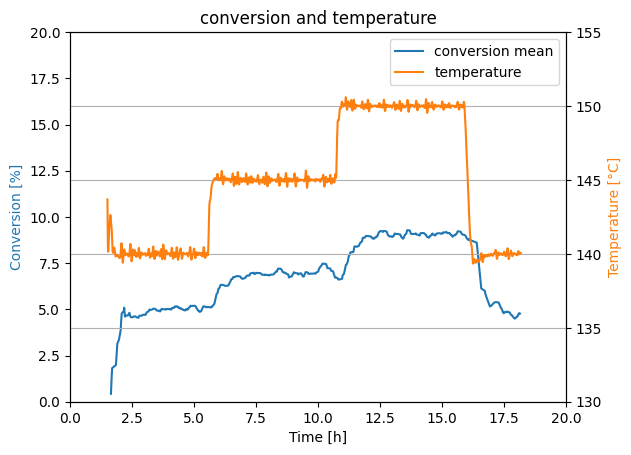

In [ ]:
# @title temperature and conversion experimental

x1 = Aziz_MSR_008['Time (h)']
x2 = Aziz_MSR_008_dropped['Time (h)']
y1 = Aziz_MSR_008_dropped['Conversion % mean2']
y2 = Aziz_MSR_008['Reactor Temperature (°C)']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x2, y1, 'tab:blue', label='conversion mean')
ax2.plot(x1, y2, 'tab:orange', label='temperature')

ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Conversion [%]', color ='tab:blue')
ax2.set_ylabel('Temperature [°C]', color ='tab:orange')
ax1.axis((0, 20, 0, 20))
ax2.axis((0, 20, 130, 155))
plt.title('conversion and temperature')
plt.legend(loc='best')
plt.grid()


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

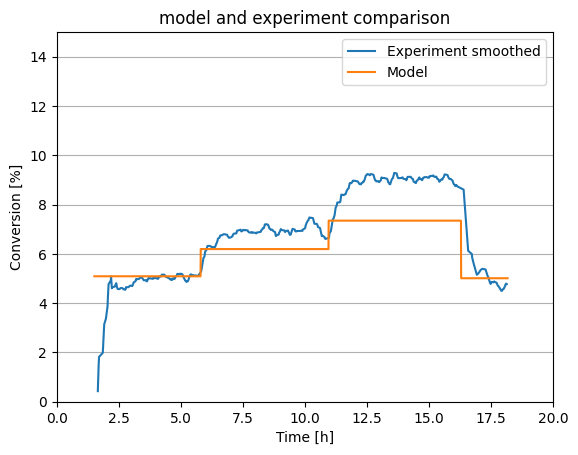

In [ ]:
# @title conversion comparison

x = Aziz_MSR_008_dropped['Time (h)']
y = Aziz_MSR_008_dropped['Conversion % mean2']

plt.figure(1)

plt.plot(x, y, label='Experiment smoothed')
plt.plot(conversion_Aziz_MSR_008_model_over_time[:, 0], conversion_Aziz_MSR_008_model_over_time[:, 1], label='Model')

plt.xlabel("Time [h]")
plt.ylabel("Conversion [%]")
plt.title('model and experiment comparison')
plt.axis((0, 20, 0, 15))
plt.legend(loc='best')

plt.grid(axis='y')

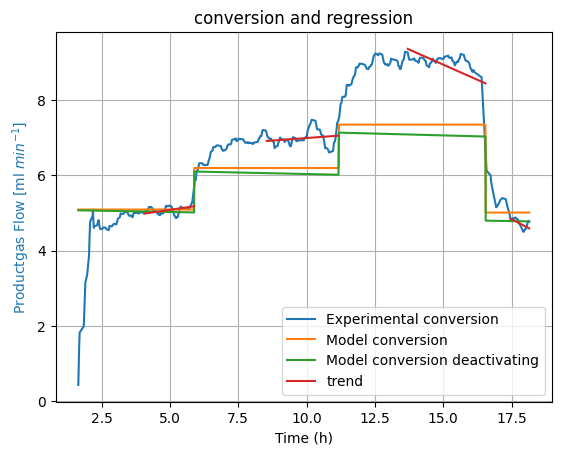

In [ ]:
# @title conversion and regression plot experimental

x008 = list(Aziz_MSR_008_dropped['Time (h)'])
y008 = list(Aziz_MSR_008_dropped['Conversion % mean2'])

x0082 = Aziz_MSR_008_deactivation_data[:, 1]
y0082 = Aziz_MSR_008_deactivation_data[:, 0]

plt.figure(1)

plt.plot(x008, y008, label='Experimental conversion')
plt.plot(x0082, y0082, label='Model conversion')
plt.plot(Xt_008[:, 1], Xt_008[:, 0], label='Model conversion deactivating')

plt.plot(Aziz_MSR_008_regression_trend[0][0], Aziz_MSR_008_regression_trend[0][1], label = 'trend', color = 'tab:red')
for i in range (len(Aziz_MSR_008_regression_trend)-1):
    plt.plot(Aziz_MSR_008_regression_trend[i+1][0], Aziz_MSR_008_regression_trend[i+1][1], color = 'tab:red')

plt.xlabel('Time (h)')
plt.ylabel('Productgas Flow [ml $min^{-1}$]', color = 'tab:blue')
#plt.axis((0, 40, 4, 14))
plt.title('conversion and regression')
plt.legend(loc='best')
plt.grid()


# 12g comparison

## data

In [ ]:
#@title data manip

file_12g_comparison_filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/Auswertung-Miniplant_231124_MSR_high_res_12g.xlsx'
file_12g_comparison = pd.read_excel(file_12g_comparison_filepath, sheet_name ='Aspen comparison', usecols='C:E, H:I').dropna()

for col in file_12g_comparison.columns:
    # get first row value for this specific column
    first_row = file_12g_comparison.iloc[0][col]
    new_column_name = col + " " + first_row
    # rename the column with the existing column header plus the first row of that column's data
    file_12g_comparison.rename(columns={col: new_column_name}, inplace=True)

file_12g_comparison = file_12g_comparison.iloc[1:]
file_12g_comparison.insert(2, 'Pressure [bar]', 1)
file_12g_comparison.insert(2, 'Temperature [K]', 150 + 273)
file_12g_comparison.insert(2, 'Mass catalyst [g]', 11.9962)
file_12g_comparison ['Conversion model %'] = 0

for i in range (len(file_12g_comparison)):
#for col in file_12g_comparison.columns:

  n_in_Aziz_12_H2O = file_12g_comparison['Water flowrate mol h-1'].iat[i]/1000
  n_in_Aziz_12_MeOH = file_12g_comparison['Methanol flowrate mol h-1'].iat[i]/1000
  IC_12 = np.array([0, n_in_Aziz_12_H2O, 0, 0, n_in_Aziz_12_MeOH, 0])

  compEul_Aziz_12 = np.zeros(len(IC_12))

  compEul_Aziz_12 = MainCalcMolFlow(IC_12, file_12g_comparison['Temperature [K]'].iat[i], file_12g_comparison['Pressure [bar]'].iat[i], 0, file_12g_comparison['Mass catalyst [g]'].iat[i]/1000)

  if n_in_Aziz_12_MeOH < n_in_Aziz_12_H2O:
    file_12g_comparison ['Conversion model %'].iat[i] = (1-compEul_Aziz_12 [4]/(n_in_Aziz_12_MeOH))*100
  else:
    file_12g_comparison ['Conversion model %'].iat[i] = (1-compEul_Aziz_12 [1]/(n_in_Aziz_12_H2O))*100

file_12g_comparison['Model Deviation %'] = (file_12g_comparison['Conversion model %'] - file_12g_comparison['Experimental conversion  %'])/file_12g_comparison['Experimental conversion  %'] * 100

In [ ]:
file_12g_comparison

,Methanol flowrate mol h-1,Water flowrate mol h-1,Mass catalyst [g],Temperature [K],Pressure [bar],Experimental conversion %,Aspen conversion %,Deviation %,Conversion model %,Model Deviation %
1,0.001708,0.001708,11.9962,423,1,32.6,100,206.748466,447.649302,1273.157368
2,0.017078,0.017078,11.9962,423,1,16.890578,36.786749,117.794502,44.764930,165.029009
3,0.034155,0.034155,11.9962,423,1,13.378896,21.833574,63.19414,22.382465,67.296806
4,0.085388,0.085388,11.9962,423,1,9.29,9.428612,1.492052,8.952986,-3.627707
5,0.170777,0.170777,11.9962,423,1,6.83,4.92565,-27.882137,4.476493,-34.458375
6,0.575517,0.575517,11.9962,423,1,4.35,1.488688,-65.777298,1.328336,-69.463535


## plots

Text(0.5, 0, 'Model conversion [%]')

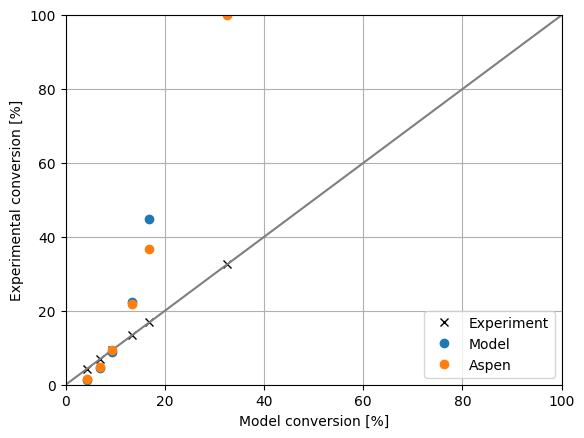

In [ ]:
#@title plot

plt.figure(1)

plt.plot(file_12g_comparison['Experimental conversion  %'], file_12g_comparison['Experimental conversion  %'], color = 'k', linestyle = 'None', marker = 'x', label = 'Experiment')
plt.plot([0, 100], [0, 100], color = 'tab:gray')
plt.plot(file_12g_comparison['Experimental conversion  %'], file_12g_comparison['Conversion model %'], marker = 'o', linestyle = 'None', label = 'Model')
plt.plot(file_12g_comparison['Experimental conversion  %'], file_12g_comparison['Aspen conversion  %'], marker = 'o', linestyle = 'None', label = 'Aspen')

plt.legend(loc='best')
plt.grid()
plt.ylim(0, 100)
plt.xlim(0, 100)

plt.ylabel('Experimental conversion [%]')
plt.xlabel('Model conversion [%]')

Text(0.5, 0, 'Model conversion [%]')

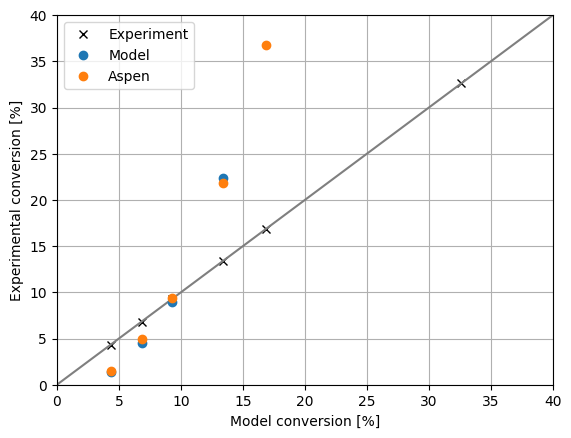

In [ ]:
#@title plot zoomed

plt.figure(1)

plt.plot(file_12g_comparison['Experimental conversion  %'], file_12g_comparison['Experimental conversion  %'], color = 'k', linestyle = 'None', marker = 'x', label = 'Experiment')
plt.plot([0, 100], [0, 100], color = 'tab:gray')
plt.plot(file_12g_comparison['Experimental conversion  %'], file_12g_comparison['Conversion model %'], marker = 'o', linestyle = 'None', label = 'Model')
plt.plot(file_12g_comparison['Experimental conversion  %'], file_12g_comparison['Aspen conversion  %'], marker = 'o', linestyle = 'None', label = 'Aspen')

plt.legend(loc='best')
plt.grid()

plt.ylim(0, 40)
plt.xlim(0, 40)

plt.ylabel('Experimental conversion [%]')
plt.xlabel('Model conversion [%]')

# least squares

8 * 17 = 136 baseline model runs per iteration

~ 1min per iteration

In [ ]:
#@title least squares finder function

def kin_squares(a, b, c, d):

    model_conversion_squares_results = np.zeros(len(kinetic_experimental))

    global A, B, C, D

    A = a
    B = b
    C = c
    D = d

    for k in range(len(kinetic_experimental)):

        n_H2O = kinetic_experimental['Flowrate [kmol/h] H2O'].iat[k]
        n_MeOH = kinetic_experimental['Flowrate [kmol/h] MeOH'].iat[k]

        IC = np.array([0, n_H2O, 0, 0, n_MeOH, 0])
        initial_conc = IC.copy()

        T = kinetic_experimental['Temperature [°C]'].iat[k] + 273
        p_in = 1
        m_cat_new = kinetic_experimental['Cat mass [kg]'].iat[k]

        results = MainCalcMolFlow(initial_conc, T, p_in, 0, m_cat_new)

        if n_MeOH <= n_H2O:
            model_conversion_squares_results[k] = ((kinetic_experimental['Conversion [%]'].iat[k] - (1 - results[4]/(n_MeOH))*100)*100)**2
        else:
            model_conversion_squares_results[k] = ((kinetic_experimental['Conversion [%]'].iat[k] - (1 - results[1]/(n_H2O))*100)*100)**2

    result_kin = model_conversion_squares_results.sum()

    return A, B, C, D, result_kin

In [ ]:
#@title least squares finder function for scipy

def kin_squares_scipy(params):

    #kinetic_experimental['Conversion Model [%]'] = 0
    model_conversion_squares_results = np.zeros(len(kinetic_experimental))

    global A, B, C, D

    a, b, c, d = params

    A = a
    B = b
    C = c
    D = d

    for k in range(len(kinetic_experimental)):

        n_H2O = kinetic_experimental['Flowrate [kmol/h] H2O'].iat[k]
        n_MeOH = kinetic_experimental['Flowrate [kmol/h] MeOH'].iat[k]

        IC_scipy = np.array([0, n_H2O, 0, 0, n_MeOH])
        initial_c = IC_scipy.copy()

        T = kinetic_experimental['Temperature [°C]'].iat[k] + 273
        p_in = 1

        m_cat_new = kinetic_experimental['Cat mass [kg]'].iat[k]

        results = MainCalcMolFlow(initial_c, T, p_in, 0, m_cat_new)

        if n_MeOH <= n_H2O:
            kinetic_experimental['Conversion Model [%]'].iat[k] = (1-results [4]/(n_MeOH))*100
        else:
            kinetic_experimental['Conversion Model [%]'].iat[k] = (1-results [1]/(n_H2O))*100

    kinetic_experimental['Squared diff'] = ((kinetic_experimental['Conversion [%]'] - kinetic_experimental['Conversion Model [%]'])*100)**2
    result_kin = kinetic_experimental['Squared diff'].sum()

    return result_kin

In [ ]:
#@title main function

'''
contains main function to call all other relevant functions and set temperature and reaction index
'''

A = 0.0188068
B = 0.06958716
C = 0.005
D = 0.005

kin_squares_result = kin_squares(A, B, C, D)

result_kin_old = kin_squares_result[4]
counter_it = 0

A_def = A
B_def = B
C_def = C
D_def = D

ls_diff = 100

A_diff = A/ls_diff
B_diff = B/ls_diff
C_diff = C/ls_diff
D_diff = D/ls_diff

while result_kin_old > 10000:

    if counter_it < 10000:
        counter_it = counter_it + 1
        #print(counter_it)

        A_new_1 = A + A_diff
        A_new_2 = A - A_diff

        B_new_1 = B + B_diff
        B_new_2 = B - B_diff

        C_new_1 = C + C_diff
        C_new_2 = C - C_diff

        D_new_1 = D + D_diff
        D_new_2 = D - D_diff

        new_kinetic_factor_array = np.array([A_new_1, A_new_2, B_new_1, B_new_2, C_new_1, C_new_2, D_new_1, D_new_2])

        result_kin_old_check = result_kin_old

        for i in range(8):
            if i < 2:
                kin_squares_result = kin_squares(new_kinetic_factor_array[i], B, C, D)
            elif i < 4:
                kin_squares_result = kin_squares(A, new_kinetic_factor_array[i], C, D)
            elif i < 6:
                kin_squares_result = kin_squares(A, B, new_kinetic_factor_array[i], D)
            else:
                kin_squares_result = kin_squares(A, B, C, new_kinetic_factor_array[i])

            if kin_squares_result[4] < result_kin_old:
                A = kin_squares_result[0]
                B = kin_squares_result[1]
                C = kin_squares_result[2]
                D = kin_squares_result[3]
                A_def = A
                B_def = B
                C_def = C
                D_def = D

                result_kin_old = kin_squares_result[4]
            else:
                A = A_def
                B = B_def
                C = C_def
                D = D_def

        if result_kin_old_check == result_kin_old:
            print('No change observed, change accuracy!')
            break
    else:
        break

print(A, B, C, D, result_kin_old)

No change observed, change accuracy!
0.0188068 0.06958716 0.005 0.005 41731.3741711582


In [ ]:
#@title scipy main

a1 = 0.005
b1 = 0.005
c1 = 0.005
d1 = 0.005

initial_guess = np.array([a1, b1, c1, d1])

bnds = [(0.0000005, 10), (0.0000005, 10), (0.0000005, 10), (0.0000005, 10)]
result = minimize(kin_squares_scipy, initial_guess, bounds = bnds, options={'tol': 1e6,'maxiter':10000})

result.x

<ipython-input-45-346a4fd9006c>:11: OptimizeWarning: Unknown solver options: tol
  result = minimize(kin_squares_scipy, initial_guess, bounds = bnds, options={'tol': 1e6,'maxiter':10000})


array([0.0188068 , 0.06958716, 0.005     , 0.005     ])